<a href="https://colab.research.google.com/github/arpanbiswas52/PaperNotebooks/blob/main/BTO_GPexplore.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Supplement of Paper Tilted:**

<h1>Electrochemical switching of polarization in thin strained films of a multiaxial ferroelectric

Anna N. Morozovska , Eugene A. Eliseev, Hanna V. Shevliakova, Arpan Biswas,  Nicholas V. Morozovsky, and Sergei V. Kalinin


-- prepared by **Arpan Biswas**

Install Packages

In [ ]:
!pip install botorch #version 0.5.0
!pip install gpytorch #version 1.5.0

     |████████████████████████████████| 486 kB 5.0 MB/s 
     |████████████████████████████████| 503 kB 35.8 MB/s 


Import functions

In [ ]:
#Import classical numpy and torch
import torch as to
import numpy as np
#Plotting
import matplotlib.pyplot as plt
#Random # generator
import random

# Import GP and BoTorch functions
import gpytorch as gpt
from botorch.models import SingleTaskGP, ModelListGP
from botorch.models.gpytorch import GPyTorchModel
from botorch.utils import standardize
from botorch import fit_gpytorch_model
from gpytorch.distributions import MultivariateNormal
from gpytorch.kernels import ScaleKernel, RBFKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.means import ConstantMean
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.acquisition import ExpectedImprovement
from botorch.sampling import IIDNormalSampler
from gpytorch.likelihoods.likelihood import Likelihood
from gpytorch.constraints import GreaterThan
from gpytorch.models import ExactGP

#Import optimizer algorithm to train GP hyperparameters
from torch.optim import SGD
from torch.optim import Adam


#Import functions required for configure hysteresis loops from PZO model and automated task to develop decision tree of functionalities from loop structures
import sympy as sym
from numpy import linalg as LA
from scipy import optimize
from scipy.signal import find_peaks
from sklearn.linear_model import LinearRegression

#other math functions
from scipy.stats import norm

<h1>Complex Physics based numerical model- bulk BTO

Below function develop the physics based numerical model using parameters for bulk BTO materials, and calculate the free energy, order parameter solutions at local minima of free energy, finally defining various phases based on the order parmater solution types

In [ ]:
def BTOsystem(T, um, rho, h, dG, l_da):

    alpha_t = 3.3*10**5
    Tp = 383
    alpha11 = 8*10**8
    alpha11_t = 3.6*10**6
    alpha12 = 4.9*10**8
    Q11 = 0.11
    Q12 = -0.043
    Q44 = 0.059
    s11 = 8.3*10**-12
    s12 = -2.7*10**-12
    s44 = 9.24*10**-12
    h=h*10**-9
    l_da = l_da*10**-9
    um = um/100
    epsilon_b = 7
    epsilon_d = 10
    epsilon_0 = 8.85*10**-12
    charge = 1.6*10**-19
    Z = [2, -2]
    n = [2, -2]
    Ai = [10**-18, 10**-18]
    kb = 1.38*10**-23
    delta_G = dG*charge
    U= 7

    f1 = (1+ np.exp(delta_G/(kb*T))*rho**(1/n[0]))**(-1)
    f2 = (1+ np.exp(delta_G/(kb*T))*rho**(1/n[1]))**(-1)
    screen = ((l_da*h)/(epsilon_0*((epsilon_d*h) + (l_da*epsilon_b))))*(((charge*Z[0]*f1)**2/(Ai[0]*kb*T)) + ((charge*Z[1]*f2)**2/(Ai[1]*kb*T)))
    #Esi = (l_da/(epsilon_0*((epsilon_d*h) + (l_da*epsilon_b))))*(((charge*Z[0]*f1)/Ai[0]) + ((charge*Z[1]*f1)/Ai[1]))
    #Ea = -(epsilon_d*U)/((epsilon_d*h) + (l_da*epsilon_b))
    Eff = 0
    alpha1 = alpha_t*(T-Tp)
    #alpha11 =(3.6*(T+222)*10**6)
    beta3 = (alpha1 - ((2*Q12*um)/(s11 + s12)))*(1 + screen) + (l_da/(2*epsilon_0*(epsilon_d*h + l_da*epsilon_b)))
    beta1 = alpha1 - (um*((Q11 + Q12)/(s11 + s12)))
    beta11 = alpha11 + ((s11*(Q11**2 + Q12**2)-2*Q11*Q12*s12)/(2*(s11**2 - s12**2))) + alpha11_t*T
    beta33 = (alpha11 + (Q12**2/(s11 + s12)) + alpha11_t*T)*(1+screen)
    beta12 = alpha12 - ((s12*(Q11**2 + Q12**2)-2*Q11*Q12*s11)/(s11**2 - s12**2)) + (Q44**2/(2*s44))
    beta13 = (alpha12 + (Q12*(Q11+Q12)/(s11 + s12)))*(1+screen)


    P1, P2, P3 = sym.symbols('P1 P2 P3')

    En = beta1*(P1**2 + P2**2) + beta3*P3**2 +  beta11*(P1**4 + P2**4) + beta33*P3**4 + beta12*P1**2*P2**2 + beta13*(P1**2+P2**2)*P3**2 -Eff*P3


    dEn_dP1 = sym.diff(En, P1)
    dEn_dP2 = sym.diff(En, P2)
    dEn_dP3 = sym.diff(En, P3)

    solP = sym.solve((dEn_dP1, dEn_dP2, dEn_dP3),(P1, P2, P3))

    #Calculate 2nd derivative and Hessian Matrix
    H=np.zeros((3,3))
    d2En_dP12 = sym.diff(dEn_dP1, P1)
    d2En_dP22 = sym.diff(dEn_dP2, P2)
    d2En_dP32 = sym.diff(dEn_dP3, P3)
    d2En_dP1dP2 = sym.diff(dEn_dP1, P2)
    d2En_dP1dP3 = sym.diff(dEn_dP1, P3)
    d2En_dP2dP1 = sym.diff(dEn_dP2, P1)
    d2En_dP2dP3 = sym.diff(dEn_dP2, P3)
    d2En_dP3dP1 = sym.diff(dEn_dP3, P1)
    d2En_dP3dP2 = sym.diff(dEn_dP3, P2)

    objeval = 0
    #sol, solEn = 0

    m=0
    sol=np.zeros((1,np.shape(solP)[1]))
    solEn = np.zeros((1))
    for i in range(0,len(solP)):
        s = solP[i]
        if ((np.absolute(sym.im(s[0]))<=1e-10) and ((np.absolute(sym.im(s[1]))<=1e-10)) and ((np.absolute(sym.im(s[2]))<=1e-10))): #solution exist

            sEn = beta1*(s[0]**2 + s[1]**2) + beta3*s[2]**2 +  beta11*(s[0]**4 + s[1]**4) + beta33*s[2]**4 + beta12*s[0]**2*s[1]**2 + beta13*(s[0]**2+s[1]**2)*s[2]**2 -Eff*s[2]
            H[0, 0] = d2En_dP12.subs(P1, s[0]).subs(P2, s[1]).subs(P3, s[2])
            H[0, 1] = d2En_dP1dP2.subs(P1, s[0]).subs(P2, s[1]).subs(P3, s[2])
            H[0, 2] = d2En_dP1dP3.subs(P1, s[0]).subs(P2, s[1]).subs(P3, s[2])
            H[1, 0] = d2En_dP2dP1.subs(P1, s[0]).subs(P2, s[1]).subs(P3, s[2])
            H[1, 1] = d2En_dP22.subs(P1, s[0]).subs(P2, s[1]).subs(P3, s[2])
            H[1, 2] = d2En_dP2dP3.subs(P1, s[0]).subs(P2, s[1]).subs(P3, s[2])
            H[2, 0] = d2En_dP3dP1.subs(P1, s[0]).subs(P2, s[1]).subs(P3, s[2])
            H[2, 1] = d2En_dP3dP2.subs(P1, s[0]).subs(P2, s[1]).subs(P3, s[2])
            H[2, 2] = d2En_dP32.subs(P1, s[0]).subs(P2, s[1]).subs(P3, s[2])

            ei, ev = LA.eig(H)
            if (min(ei)>=0): #hessian positive definite, necessary cond for local minima

                if (m==0):
                    sol[m,:]=s
                    solEn[m] = sEn
                else:
                    sol =np.vstack((sol,s))
                    solEn = np.vstack((solEn,sEn))
                m=m+1
            else: #hessian is not positive semi-definite
                m=m
        else: #solution does not exist
            m=m


    #Compute objective values from order parameters, to define phases
    #P1P2plus_max = max(np.absolute((sol[:, 0]) + (sol[:, 1])))
    P1P2diff = max(np.absolute(sol[:,0]))-max(np.absolute(sol[:,1]))
    if (m == 0): #FEI, no solution, P1=P2=P3=0
        objeval1 = 0+np.random.uniform(0,1,1).__float__()
        objeval2 = 0

    if (m == 1):  # PE, P1=P2=P3=0

        objeval1 = 1+np.random.uniform(0,1,1).__float__()
        objeval2 = np.min(solEn).__float__() #Choosing the most lower min free energy among all the possible solutions of order parameter vector P
    elif (m == 2):  # can be FEa or FEc or FEaa

        if ((max(np.absolute(sol[:,1]))==0) and (max(np.absolute(sol[:,2]))==0)): #FEa, P2=P3=0
            objeval1 = 2+np.random.uniform(0,1,1).__float__()
            objeval2 = np.min(solEn).__float__()  # Choosing the most lower min free energy among all the possible solutions of order parameter vector P
        elif (((max(np.absolute(sol[:,0]))==0)) and ((max(np.absolute(sol[:,1]))==0))):#FEc, P1=P2=0
            objeval1 = 3+np.random.uniform(0,1,1).__float__()
            objeval2 = np.min(solEn).__float__()  # Choosing the most lower min free energy among all the possible solutions of order parameter vector P
        elif ((max(np.absolute(sol[:,2]))==0) and (P1P2diff<=1e-5)): #FEaa, P3=0, abs(P1)=abs(P2)
            objeval1 = 4+np.random.uniform(0,1,1).__float__()
            objeval2 = np.min(solEn).__float__()
        elif ((max(np.absolute(sol[:, 1])) == 0) and (max(np.absolute(sol[:,0]))>0) and (max(np.absolute(sol[:,2]))>0)):  # FEac, P2=0
            objeval1 = 5 + np.random.uniform(0, 1, 1).__float__()
            objeval2 = np.min(solEn).__float__()
        else:
            objeval1 = -1+np.random.uniform(0,1,1).__float__()
            objeval2 = np.min(solEn).__float__()

    elif (m == 4): #can be FEaa or FEac or FEr
        if ((max(np.absolute(sol[:,2]))==0) and (P1P2diff<=1e-5)): #Feaa, P3=0, abs(P1)=abs(P2)
            objeval1 = 4+np.random.uniform(0,1,1).__float__()
            objeval2 = np.min(solEn).__float__()
        elif (max(np.absolute(sol[:,1]))==0): #FEac, P2=0
            objeval1 = 5+np.random.uniform(0,1,1).__float__()
            objeval2 = np.min(solEn).__float__()
        elif ((P1P2diff<=1e-5) and (max(np.absolute(sol[:,2])) > 0) and (max(np.absolute(sol[:,0])) > 0)): #FEr (FEaac)
            objeval1 = 6+np.random.uniform(0,1,1).__float__()
            objeval2 = np.min(solEn).__float__()
        else:
            objeval1 = -1+np.random.uniform(0,1,1).__float__()
            objeval2 = np.min(solEn).__float__()

    elif(m>=6):
        if ((max(np.absolute(sol[:,0]))>0) and (max(np.absolute(sol[:,1]))>0) and (max(np.absolute(sol[:,2]))>0)): #FEr (FEabc), P1, P2, P3 Not zero
            objeval1 = 6+np.random.uniform(0,1,1).__float__()
            objeval2 = np.min(solEn).__float__()
        else:
            objeval1 = -1+np.random.uniform(0,1,1).__float__()
            objeval2 = np.min(solEn).__float__()

    return objeval1, objeval2, sol, solEn, beta3


<h1> Now, we define classes/functions for GP exploration of phase and free energy diagrams

Below section defines the list of functions (user calls these functions during analysis):
1. Gaussian Process
2. Optimizize Hyperparameter of Gaussian Process (using Adam optimizer)
3. Posterior means and variance computation
4. Acquistion functions used is full exploration (as we want to obtain the phase diagram in the overall parameter space)

GP models are configured using GPyTorch package and to handle multiple independent GP models (for individual objectives), we utilize multi-output GP function, ModelListGP

In [ ]:
###################################### Functions for components BO model- GP and acquistion functions ######################

class SimpleCustomGP(ExactGP, GPyTorchModel):
    _num_outputs = 1  # to inform GPyTorchModel API

    def __init__(self, train_X, train_Y):
        # squeeze output dim before passing train_Y to ExactGP
        super().__init__(train_X, train_Y.squeeze(-1), GaussianLikelihood())
        self.mean_module = ConstantMean()
        self.covar_module = ScaleKernel(
            base_kernel=RBFKernel(ard_num_dims=train_X.shape[-1]),
        )
        self.to(train_X)  # make sure we're on the right device/dtype

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultivariateNormal(mean_x, covar_x)


############## Optimize Hyperparameters of GP##############################
def optimize_hyperparam_trainGP(train_X_norm, train_Y_norm):
    # Gp model fit

    gp_surro1 = SimpleCustomGP(train_X_norm, train_Y_norm[:, 0])
    gp_surro2 = SimpleCustomGP(train_X_norm, train_Y_norm[:, 1])
    gp_surro = ModelListGP(gp_surro1, gp_surro2)
    gp_surro = gp_surro.double()
    gp_surro.likelihood.likelihoods[0].noise_covar.register_constraint("raw_noise", GreaterThan(1e-1))
    gp_surro.likelihood.likelihoods[1].noise_covar.register_constraint("raw_noise", GreaterThan(1e-1))
    mll1 = ExactMarginalLogLikelihood(gp_surro.likelihood.likelihoods[0], gp_surro.models[0])
    mll2 = ExactMarginalLogLikelihood(gp_surro.likelihood.likelihoods[1], gp_surro.models[1])
    # fit_gpytorch_model(mll)
    mll1 = mll1.to(train_X_norm)
    mll2 = mll2.to(train_X_norm)
    gp_surro.models[0].train()
    gp_surro.likelihood.likelihoods[0].train()
    gp_surro.models[1].train()
    gp_surro.likelihood.likelihoods[1].train()
    ## Here we use Adam optimizer with learning rate =0.2, user can change here with different algorithm and/or learning rate for each GP
    optimizer1 = Adam([{'params': gp_surro.models[0].parameters()}], lr=0.1)
    optimizer2 = Adam([{'params': gp_surro.models[1].parameters()}], lr=0.1)

    NUM_EPOCHS = 150

    for epoch in range(NUM_EPOCHS):
        # clear gradients
        optimizer1.zero_grad()
        optimizer2.zero_grad()
        # forward pass through the model to obtain the output MultivariateNormal
        output1 = gp_surro.models[0](train_X_norm)
        output2 = gp_surro.models[1](train_X_norm)
        # Compute negative marginal log likelihood
        loss1 = - mll1(output1, gp_surro.models[0].train_targets)
        loss2 = - mll2(output2, gp_surro.models[1].train_targets)
        # back prop gradients
        loss1.backward(retain_graph=True)
        # back prop gradients
        loss2.backward(retain_graph=True)
        # print last iterations
        if (epoch + 1) > NUM_EPOCHS: #Stopping the print for now
            print("GP Model trained:")
            print("Iteration:" + str(epoch + 1))
            print("Loss for ob1:" + str(loss1.item()))
            print("Loss for ob2:" + str(loss2.item()))
            # print("Length Scale:" +str(gp_PZO.covar_module.base_kernel.lengthscale.item()))
            print("noise for obj1:" + str(gp_surro.likelihood.likelihoods[0].noise.item()))
            print("noise for obj2:" + str(gp_surro.likelihood.likelihoods[1].noise.item()))

        optimizer1.step()
        optimizer2.step()

    gp_surro.models[0].eval()
    gp_surro.likelihood.likelihoods[0].eval()
    gp_surro.models[1].eval()
    gp_surro.likelihood.likelihoods[1].eval()
    return gp_surro

##########################GP posterior predictions#############################
def cal_posterior(gp_surro, testX1_norm, testX2_norm, t_y, num_rows):
    y_pred_means = to.empty(num_rows, num_rows, 2)
    y_pred_vars = to.empty(num_rows, num_rows, 2)
    for t1, (x1, x2, y1, y2) in enumerate(zip(testX1_norm, testX2_norm, t_y[:, :, 0], t_y[:, :, 1])):
        for t2, (xx1, xx2, yy1, yy2) in enumerate(zip(x1, x2, y1, y2)):

            if (xx1 == -1 and xx2 == -1):
                y_pred_means[t1, t2, 0] = yy1
                y_pred_vars[t1, t2, 0] = 1e-8
                y_pred_means[t1, t2, 1] = yy2
                y_pred_vars[t1, t2, 1] = 1e-8
            else:
                test_X = to.empty(1, 2)
                test_X[:, 0] = xx1
                test_X[:, 1] = xx2
                test_X = test_X.double()
                with to.no_grad(), gpt.settings.max_lanczos_quadrature_iterations(32), \
                     gpt.settings.fast_computations(covar_root_decomposition=False, log_prob=False,
                                                    solves=True), \
                     gpt.settings.max_cg_iterations(100), \
                     gpt.settings.max_preconditioner_size(80), \
                     gpt.settings.num_trace_samples(128):
                    y1_pred_surro, y2_pred_surro = gp_surro.models[0].posterior(test_X), gp_surro.models[1].posterior(test_X)
                    y_pred_means[t1, t2, 0] = y1_pred_surro.mean
                    y_pred_vars[t1, t2, 0] = y1_pred_surro.variance
                    y_pred_means[t1, t2, 1] = y2_pred_surro.mean
                    y_pred_vars[t1, t2, 1] = y2_pred_surro.variance

    return y_pred_means, y_pred_vars

#########################################Full exploration ###########################################
def acqexplore(y_pred_means, y_pred_vars):
    y_pred_means = y_pred_means.detach().numpy()
    y_pred_vars = y_pred_vars.detach().numpy()
    y_pred_vars_sum = np.nansum(y_pred_vars, axis =2)
    y_pred_vars_sum = np.reshape(y_pred_vars_sum, (num_rows ** 2, 1))
    acq_val = np.max(y_pred_vars_sum)
    acq_cand = [k for k, j in enumerate(y_pred_vars_sum) if j == acq_val]
    return acq_cand, acq_val

Other function-

Evaluate initial data and normalize all data

In [ ]:
# Normalize all data. It is very important to fit GP model with normalized data to avoid issues such as
# - decrease of GP performance due to largely spaced real-valued data X
def normalize_get_initialdata_BTO(X1, X2, fix_x, test_X1, test_X2, num_rows, num, m):
#Normalize X
    minX1 = min(X1)
    maxX1 = max(X1)
    minX2 = min(X2)
    maxX2 = max(X2)
    Xmin = np.hstack((minX1, minX2))
    Xmax = np.hstack((maxX1, maxX2))
    X1, X2 = np.meshgrid(X1, X2)
    test_X1, test_X2 = np.meshgrid(test_X1, test_X2)
    X1_norm = (X1-Xmin[0])/(Xmax[0]-Xmin[0])
    X2_norm = (X2-Xmin[1])/(Xmax[1]-Xmin[1])
    testX1_norm = (test_X1-Xmin[0])/(Xmax[0]-Xmin[0])
    testX2_norm = (test_X2-Xmin[1])/(Xmax[1]-Xmin[1])

    # Select starting samples randomly as training data
    testX1_norm = np.reshape(testX1_norm, (num_rows ** 2, 1))
    testX2_norm = np.reshape(testX2_norm, (num_rows ** 2, 1))
    test_X1 = np.reshape(test_X1, (num_rows ** 2, 1))
    test_X2 = np.reshape(test_X2, (num_rows ** 2, 1))
    np.random.seed(10)
    ind_start = np.random.choice(len(testX1_norm) - 1, size=num, replace=False)
    train_X = np.zeros((num, 2))
    train_X_norm = np.zeros((num, 2))
    train_y = np.zeros((num, 2))
    t_y = np.zeros((num_rows**2,2))
    m=0
    print("Function evaluaton for initial randomly selected samples")
    for i in range(0, num):
        train_X_norm[i, 0] = testX1_norm[ind_start[i]]
        train_X_norm[i, 1] = testX2_norm[ind_start[i]]
        train_X[i, 0]= test_X1[ind_start[i]]
        train_X[i, 1]= test_X2[ind_start[i]]
        print("Function eval: " + str(m + 1))
        rho = fix_x[0]
        h = fix_x[1]
        dG =fix_x[2]
        l_da = fix_x[3]
        objphase, objEn, sol, solEn, beta3 = BTOsystem(train_X[i, 1], train_X[i, 0], rho, h, dG, l_da)
        train_y[i, 0] = objphase  # By default, BO settting is for maximization, for minimization we just use f(x) =-f(x)
        t_y[ind_start[i], 0] = objphase  # By default, BO settting is for maximization, for minimization we just use f(x) =-f(x)
        train_y[i, 1] = objEn  # By default, BO settting is for maximization, for minimization we just use f(x) =-f(x)
        t_y[ind_start[i], 1] = objEn
        #testX1_norm[ind_start[i]] =-1
        #testX2_norm[ind_start[i]] =-1
        m = m + 1

    testX1_norm = np.reshape(testX1_norm, (num_rows, num_rows))
    testX2_norm = np.reshape(testX2_norm, (num_rows, num_rows))
    t_y = np.reshape(t_y, (num_rows, num_rows, 2))

    #Convert to torch
    train_X_norm = to.from_numpy(train_X_norm)
    train_X_norm = train_X_norm.double()
    train_Y = to.from_numpy(train_y)
    #Normalize Y
    testY1_norm = (train_Y[:,0]-train_Y[:,0].min())/(train_Y[:,0].max()-train_Y[:,0].min())
    testY2_norm = (train_Y[:,1]-train_Y[:,1].min())/(train_Y[:,1].max()-train_Y[:,1].min())
    train_Y_norm = to.empty(train_Y.__len__(), 2)
    train_Y_norm[:,0]=testY1_norm
    train_Y_norm[:,1]=testY2_norm

    return X1_norm, X2_norm, testX1_norm, testX2_norm, train_X, train_X_norm, train_Y, train_Y_norm, Xmin, Xmax, t_y, m

Plotting function- Get phase diagrams

In [ ]:
def plot_exploration_results(X1, X2, Gp_y_mu, Gp_y_var, train_X, train_X_norm, train_Y, iter):
    fig, ax = plt.subplots(3, 2, figsize=(10, 15))
    ax[0, 0].imshow(X1, origin='bottom', cmap='viridis')
    ax[0, 1].imshow(X2, origin='bottom', cmap='viridis')
    ax[1, 0].imshow(Gp_y_mu[:,:,0].detach().numpy(), origin='bottom', cmap='viridis', extent=[-0.05, 1.05, -0.05, 1.05])
    ax[1, 0].scatter(train_X_norm[:, 0].detach().numpy(), train_X_norm[:, 1].detach().numpy(), cmap='reds', linewidth=1)
    ax[1, 1].imshow(Gp_y_var[:,:,0].detach().numpy(), origin='bottom', cmap='viridis', extent=[-0.05, 1.05, -0.05, 1.05])
    ax[2, 0].imshow(Gp_y_mu[:,:,1].detach().numpy(), origin='bottom', cmap='viridis', extent=[-0.05, 1.05, -0.05, 1.05])
    ax[2, 0].scatter(train_X_norm[:, 0].detach().numpy(), train_X_norm[:, 1].detach().numpy(), cmap='reds', linewidth=1)
    ax[2, 1].imshow(Gp_y_var[:,:,1].detach().numpy(), origin='bottom', cmap='viridis', extent=[-0.05, 1.05, -0.05, 1.05])

    ax[1, 0].set_title("GP prediction (phase), iter=" + str(iter))
    ax[1, 1].set_title("Uncertainty, iter=" + str(iter))
    ax[2, 0].set_title("GP prediction (En), iter=" + str(iter))
    ax[2, 1].set_title("Uncertainty, iter=" + str(iter))
    plt.show()
    # plt.colorbar()

    plt.scatter(train_X[:, 0], train_X[:, 1], cmap='reds', linewidth=1)
    plt.title('Sampling done at iter =' + str(iter))
    plt.show()



<h1> GP exploration

This function forms the GP exploration framework by integrating the earlier defined building blocks (functions) as appropiate

In [ ]:
#GP/BO framework

def GP_BTO(X1, X2, fix_x, test_X1, test_X2, num_rows, num, N):


    m = 0
    # Initialization: evaluate few initial data normalize data
    X1_norm, X2_norm, testX1_norm, testX2_norm, train_X, train_X_norm, train_Y, train_Y_norm, Xmin, Xmax, t_y, m = \
        normalize_get_initialdata_BTO(X1, X2, fix_x, test_X1, test_X2, num_rows, num, m)

    X1, X2 = np.meshgrid(X1, X2)
    test_X1, test_X2 = np.meshgrid(test_X1, test_X2)

    print("Initial evaluation complete. Start GP explore")
    ## Gp model fit
    # Calling function to fit and optimizize Hyperparameter of Gaussian Process (using Adam optimizer)
    # Input args- Torch arrays of normalized training data, parameter X and objective eval Y
    # Output args- Gaussian process model lists
    gp_surro = optimize_hyperparam_trainGP(train_X_norm, train_Y_norm)

    for i in range(1, N + 1):
        # Calculate posterior for analysis for intermidiate iterations
        y_pred_means, y_pred_vars = cal_posterior(gp_surro, testX1_norm, testX2_norm, t_y, num_rows)
        if (i == 1 or i == 10 or i == 30 or i == 50 or i == 80 or i == 100 or i == 150 or i == 200 or i == 250):

            # Plotting functions to check the current state exploration and Pareto fronts
            plot_exploration_results(X1, X2, y_pred_means, y_pred_vars, train_X, train_X_norm, train_Y, i)

        acq_cand, acq_val = acqexplore(y_pred_means, y_pred_vars)
        val = acq_val
        ind = np.random.choice(acq_cand)

        ################################################################
        ## Find next point which maximizes the learning through exploration
        if (i == 1):
            val_ini = val
        # Check for convergence
        if ((val) < 0):  # Stop for negligible expected improvement
            print("Model converged due to sufficient learning over search space ")
            break
        else:
            # Evaluate true function for new data, augment data
            nextX =np.zeros((1,2))
            nextX_norm = to.empty(1, 2)
            next_feval = to.empty(1, 2)
            test_X1 = np.reshape(test_X1, (num_rows ** 2, 1))
            test_X2 = np.reshape(test_X2, (num_rows ** 2, 1))
            testX1_norm = np.reshape(testX1_norm, (num_rows ** 2, 1))
            testX2_norm = np.reshape(testX2_norm, (num_rows ** 2, 1))
            t_y = np.reshape(t_y, (num_rows ** 2, 2))

            nextX_norm[0, 0] = to.from_numpy(testX1_norm[ind])
            nextX_norm[0, 1] = to.from_numpy(testX2_norm[ind])
            #testX1_norm[ind] = -1
            #testX2_norm[ind] = -1
            train_X_norm = to.cat((train_X_norm, nextX_norm), 0)
            train_X_norm = train_X_norm.double()

            testX1_norm = np.reshape(testX1_norm, (num_rows, num_rows))
            testX2_norm = np.reshape(testX2_norm, (num_rows, num_rows))

            train_X = np.vstack((train_X,np.hstack((test_X1[ind], test_X2[ind]))))
            print("Function eval: " + str(m + 1))
            rho = fix_x[0]
            h = fix_x[1]
            dG = fix_x[2]
            l_da = fix_x[3]
            #print(train_X[-1, :])
            objphase, objEn, sol, solEn, beta3 = BTOsystem(train_X[-1, 1], train_X[-1, 0], rho, h, dG, l_da)
            next_feval[:, 0] = objphase
            next_feval[:, 1] = objEn
            t_y[ind, 0] = objphase
            t_y[ind, 1] = objEn
            #train_X, train_X_norm, train_Y, train_Y_norm, m = augment_newdata_BTO(acq_X, train_X, train_X_norm, train_Y, fix_x, Xmin, Xmax, num_rows, m)
            train_Y = to.cat((train_Y, next_feval), 0)
            # Normalize Y
            testY1_norm = (train_Y[:, 0] - train_Y[:, 0].min()) / (train_Y[:, 0].max() - train_Y[:, 0].min())
            testY2_norm = (train_Y[:, 1] - train_Y[:, 1].min()) / (train_Y[:, 1].max() - train_Y[:, 1].min())
            train_Y_norm = to.empty(train_Y.__len__(), 2)
            train_Y_norm[:, 0] = testY1_norm
            train_Y_norm[:, 1] = testY2_norm

            t_y = np.reshape(t_y, (num_rows, num_rows, 2))
            m = m + 1

            # Gp model fit
            # Updating GP with augmented training data
            gp_surro = optimize_hyperparam_trainGP(train_X_norm, train_Y_norm)

    ## Final posterior prediction after all the sampling done

    if (i == N):
        print("Max. sampling reached, model stopped")

    # Posterior calculation with converged GP model
    y_pred_means, y_pred_vars = cal_posterior(gp_surro, testX1_norm, testX2_norm, t_y, num_rows)
    # Plotting functions to check final exploration
    plot_exploration_results(X1, X2, y_pred_means, y_pred_vars, train_X, train_X_norm, train_Y, i)

    plt.show()


<h1> Low sampling based exhasutive search

Lets do an exhaustive search with sparse maps (low sampling)

<h1> Analysis 1

**Parameter space**:

Temp: $T (K)= [200, 500]$
Strain mismatch: $u_m$ (%) $= [-1, 1]$

**Other fixed parameters**:

Partial O2 pressure, $\rho = 10^{-6}$

film thickness, $h = 50 nm$ 

surface ion energy, $\Delta_G = 0.2 eV$

Width of dielectric gap, $\lambda = 0.4 nm$

Analysis:1
Analysis:2
Analysis:3
Analysis:4
Analysis:5
Analysis:6
Analysis:7
Analysis:8
Analysis:9
Analysis:10
Analysis:11
Analysis:12
Analysis:13
Analysis:14
Analysis:15
Analysis:16
Analysis:17
Analysis:18
Analysis:19
Analysis:20
Analysis:21
Analysis:22
Analysis:23
Analysis:24
Analysis:25
Analysis:26
Analysis:27
Analysis:28
Analysis:29
Analysis:30
Analysis:31
Analysis:32
Analysis:33
Analysis:34
Analysis:35
Analysis:36
Analysis:37
Analysis:38
Analysis:39
Analysis:40
Analysis:41
Analysis:42
Analysis:43
Analysis:44
Analysis:45
Analysis:46
Analysis:47
Analysis:48
Analysis:49
Analysis:50
Analysis:51
Analysis:52
Analysis:53
Analysis:54
Analysis:55
Analysis:56
Analysis:57
Analysis:58
Analysis:59
Analysis:60
Analysis:61
Analysis:62
Analysis:63
Analysis:64
Analysis:65
Analysis:66
Analysis:67
Analysis:68
Analysis:69
Analysis:70
Analysis:71
Analysis:72
Analysis:73
Analysis:74
Analysis:75
Analysis:76
Analysis:77
Analysis:78
Analysis:79
Analysis:80
Analysis:81
Analysis:82
Analysis:83
Analysis:84
A

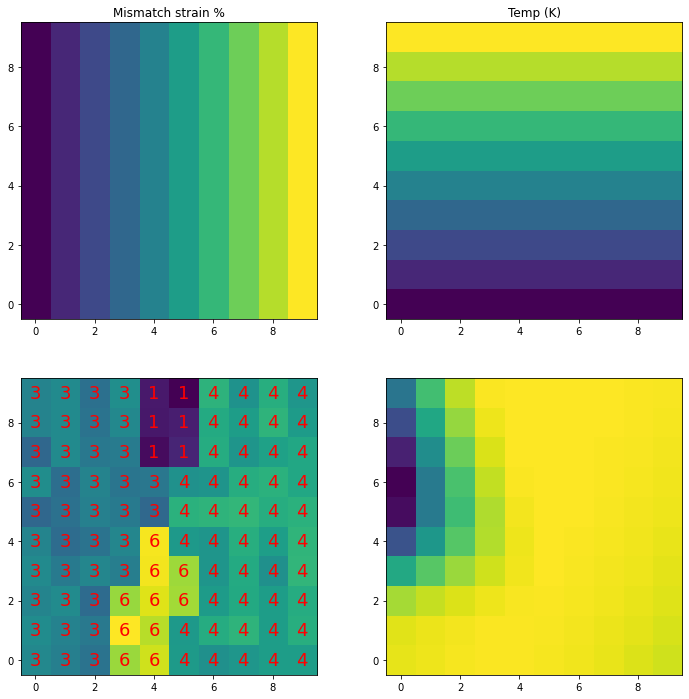

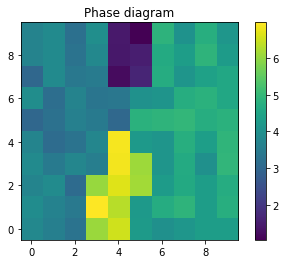

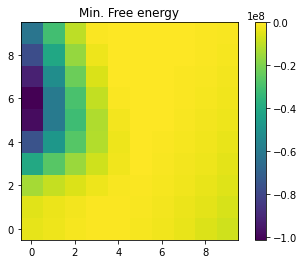

In [ ]:
# ###### Phase diagram################
num_rows = 10
T= np.linspace(200, 500, num_rows)
um = np.linspace(-1, 1, num_rows)
rho = 10**-6
h= 50
dG = 0.2
l_da = 0.4
#prho = np.linspace(0, 6, nrow)
#h = np.linspace(5, 50, nrow)
#l_da = np.linspace(0.4, 2, nrow)

X1 = um
X2 = T

X1, X2 = np.meshgrid(X1, X2)
true_Y1 = np.zeros((len(X1), len(X1)))
true_Y2 = np.zeros((len(X1), len(X1)))
m=0
for t1, (x1, x2) in enumerate(zip(X1, X2)):
    for t2, (xx1, xx2) in enumerate(zip(x1, x2)):
        m = m + 1
        print("Analysis:" + str(m))
        #print(xx1)
        #print(xx2)
        objphase, objEn, sol, solEn, beta3 = BTOsystem(xx2, xx1, rho, h, dG, l_da)
        true_Y1[t1, t2] = objphase
        true_Y2[t1, t2] = objEn



# Plot Phase domain and free energy grid image for each A
fig, ax = plt.subplots(2, 2, figsize=(12, 12))
ax[0,0].imshow(X1, origin='bottom', cmap='viridis')
ax[0,1].imshow(X2, origin='bottom', cmap='viridis')
ax[1,0].imshow(true_Y1, origin='bottom', cmap='viridis')
ax[1,1].imshow(true_Y2, origin='bottom', cmap='viridis')
for i in range(0, true_Y1.shape[0]):
    for j in range(0, true_Y1.shape[1]):
        c1 = int(true_Y1[j, i])
        ax[1,0].text(i, j, str(c1), color='red', va='center', ha='center', size=18)


ax[0,0].set_title('Mismatch strain %')
ax[0,1].set_title('Temp (K)')
# ax[1,0].set_title('Phase diagram')
# ax[1,1].set_title('Min. Free energy')
plt.show()

#Adding colobar
plt.imshow(true_Y1, origin='bottom', cmap='viridis')
plt.title('Phase diagram')
plt.colorbar()
plt.show()

plt.imshow(true_Y2, origin='bottom', cmap='viridis')
plt.title('Min. Free energy')
plt.colorbar()
plt.show()


Now lets do dense exploration with cheap (low computational cost) surrogate GP model

Function evaluaton for initial randomly selected samples
Function eval: 1
Function eval: 2
Function eval: 3
Function eval: 4
Function eval: 5
Function eval: 6
Function eval: 7
Function eval: 8
Function eval: 9
Function eval: 10
Function eval: 11
Function eval: 12
Function eval: 13
Function eval: 14
Function eval: 15
Function eval: 16
Function eval: 17
Function eval: 18
Function eval: 19
Function eval: 20
Initial evaluation complete. Start GP explore


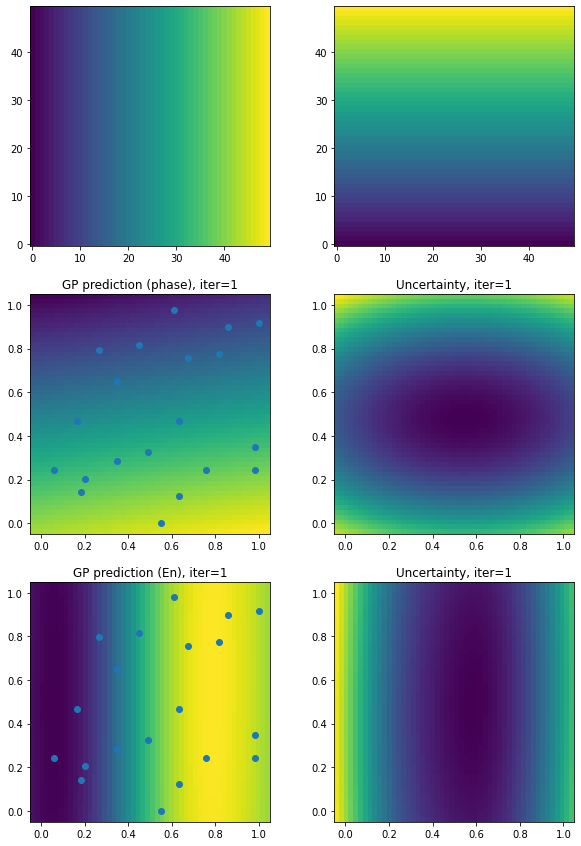

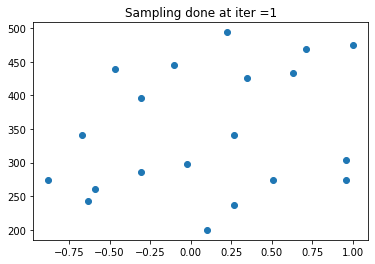

Function eval: 21
Function eval: 22
Function eval: 23
Function eval: 24
Function eval: 25
Function eval: 26
Function eval: 27
Function eval: 28
Function eval: 29


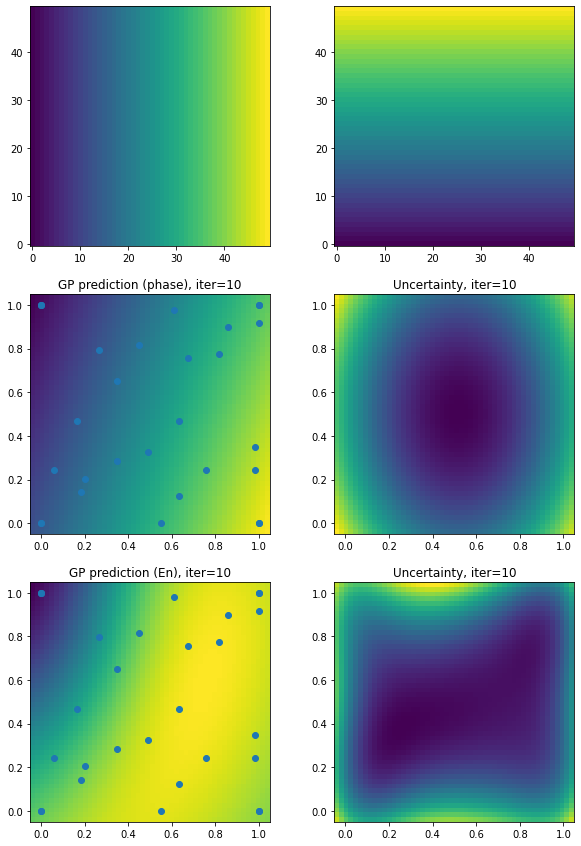

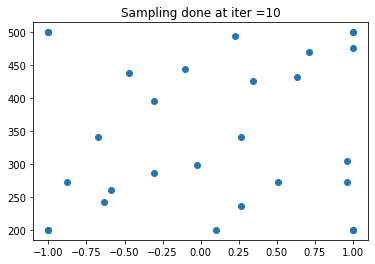

Function eval: 30
Function eval: 31
Function eval: 32
Function eval: 33
Function eval: 34
Function eval: 35
Function eval: 36
Function eval: 37
Function eval: 38
Function eval: 39
Function eval: 40
Function eval: 41
Function eval: 42
Function eval: 43
Function eval: 44
Function eval: 45
Function eval: 46
Function eval: 47
Function eval: 48
Function eval: 49


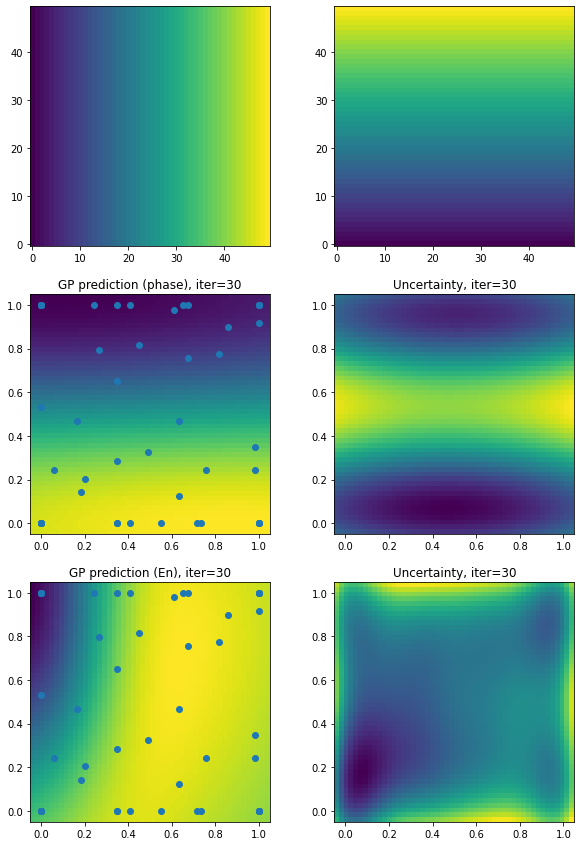

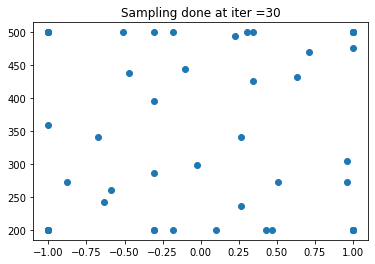

Function eval: 50
Function eval: 51
Function eval: 52
Function eval: 53
Function eval: 54
Function eval: 55
Function eval: 56
Function eval: 57
Function eval: 58
Function eval: 59
Function eval: 60
Function eval: 61
Function eval: 62
Function eval: 63
Function eval: 64
Function eval: 65
Function eval: 66
Function eval: 67
Function eval: 68
Function eval: 69


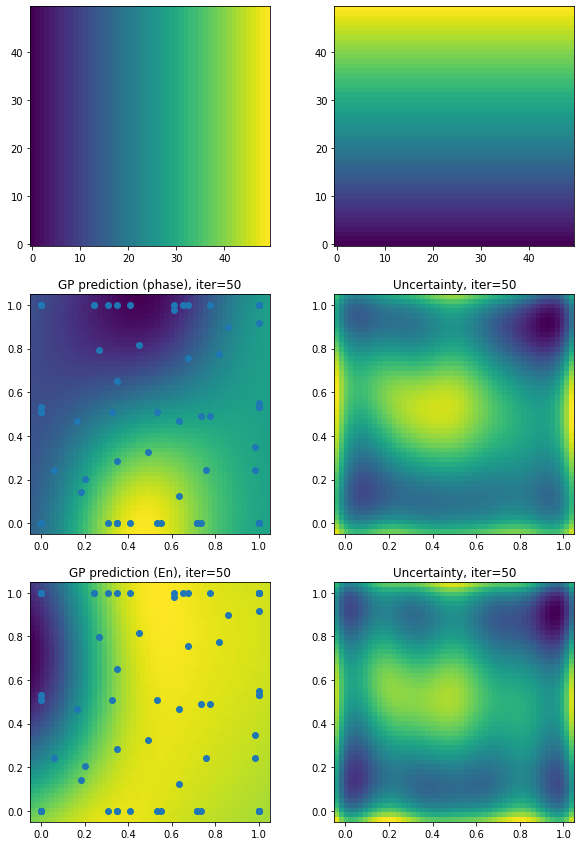

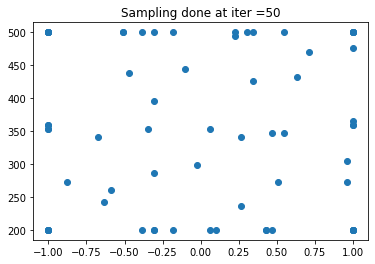

Function eval: 70
Function eval: 71
Function eval: 72
Function eval: 73
Function eval: 74
Function eval: 75
Function eval: 76
Function eval: 77
Function eval: 78
Function eval: 79
Function eval: 80
Function eval: 81
Function eval: 82
Function eval: 83
Function eval: 84
Function eval: 85
Function eval: 86
Function eval: 87
Function eval: 88
Function eval: 89
Function eval: 90
Function eval: 91
Function eval: 92
Function eval: 93
Function eval: 94
Function eval: 95
Function eval: 96
Function eval: 97
Function eval: 98
Function eval: 99


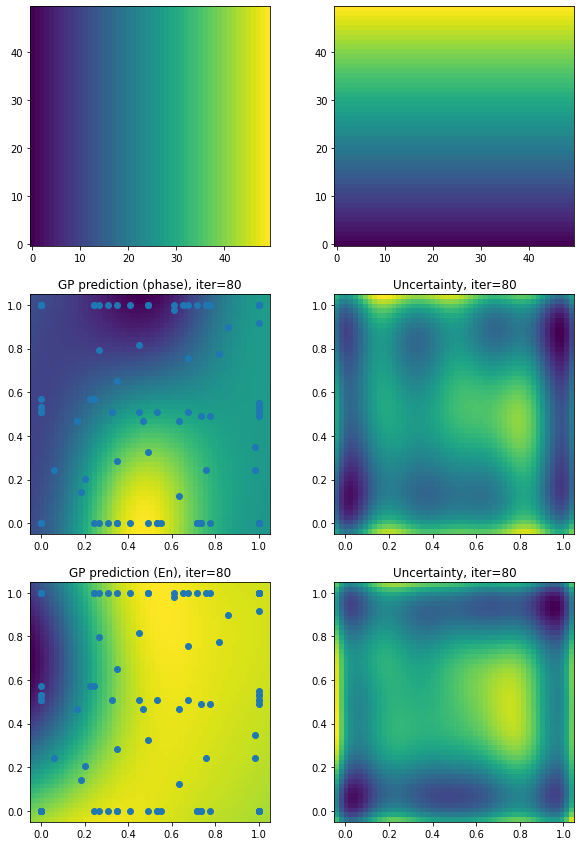

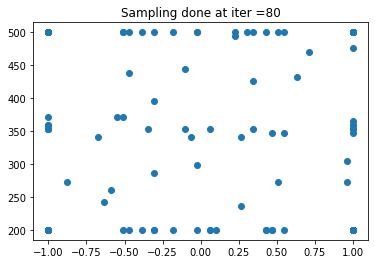

Function eval: 100
Function eval: 101
Function eval: 102
Function eval: 103
Function eval: 104
Function eval: 105
Function eval: 106
Function eval: 107
Function eval: 108
Function eval: 109
Function eval: 110
Function eval: 111
Function eval: 112
Function eval: 113
Function eval: 114
Function eval: 115
Function eval: 116
Function eval: 117
Function eval: 118
Function eval: 119


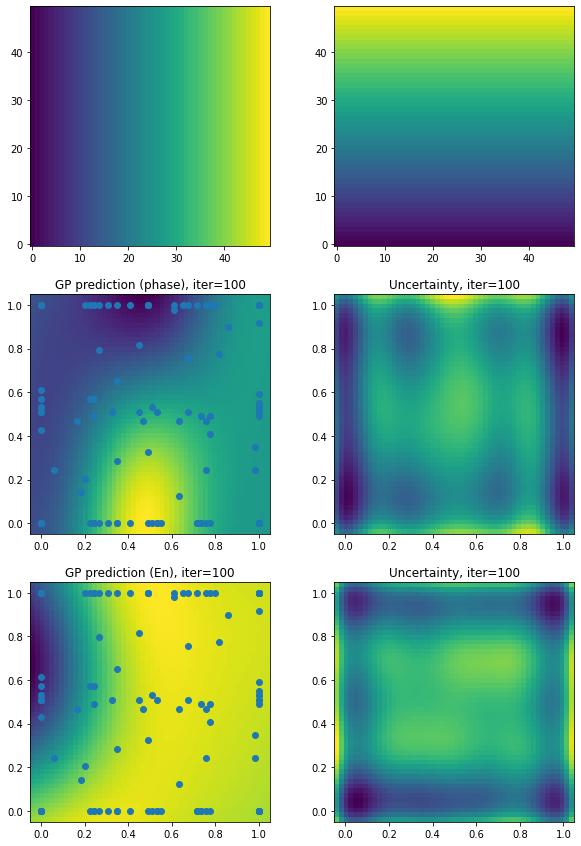

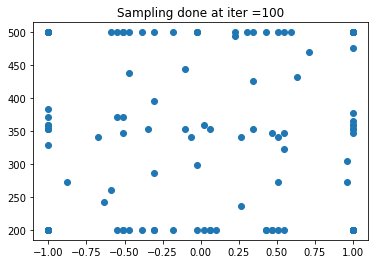

Function eval: 120
Function eval: 121
Function eval: 122
Function eval: 123
Function eval: 124
Function eval: 125
Function eval: 126
Function eval: 127
Function eval: 128
Function eval: 129
Function eval: 130
Function eval: 131
Function eval: 132
Function eval: 133
Function eval: 134
Function eval: 135
Function eval: 136
Function eval: 137
Function eval: 138
Function eval: 139
Function eval: 140
Function eval: 141
Function eval: 142
Function eval: 143
Function eval: 144
Function eval: 145
Function eval: 146
Function eval: 147
Function eval: 148
Function eval: 149
Function eval: 150
Function eval: 151
Function eval: 152
Function eval: 153
Function eval: 154
Function eval: 155
Function eval: 156
Function eval: 157
Function eval: 158
Function eval: 159
Function eval: 160
Function eval: 161
Function eval: 162
Function eval: 163
Function eval: 164
Function eval: 165
Function eval: 166
Function eval: 167
Function eval: 168
Function eval: 169


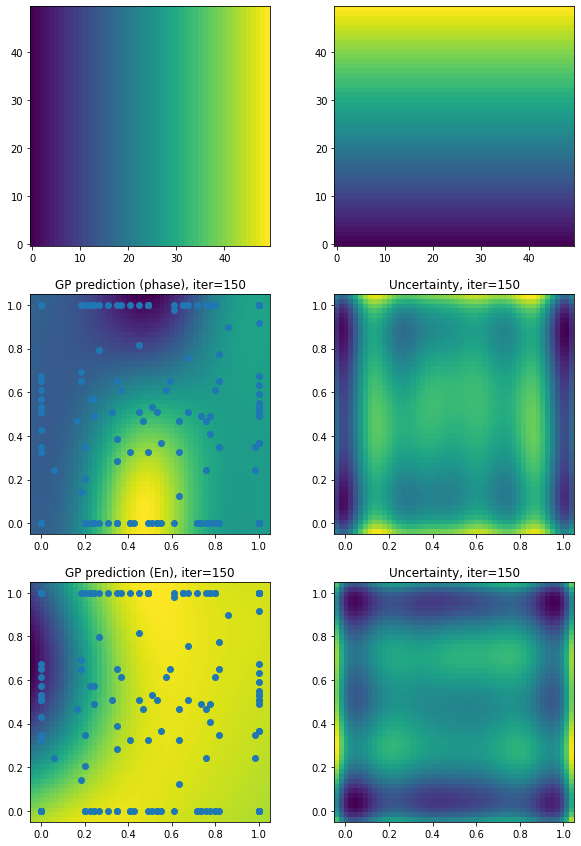

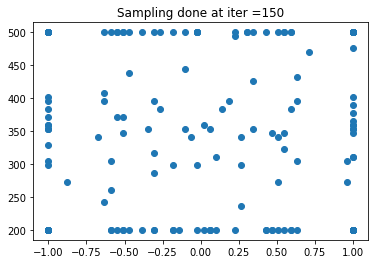

Function eval: 170
Function eval: 171
Function eval: 172
Function eval: 173
Function eval: 174
Function eval: 175
Function eval: 176
Function eval: 177
Function eval: 178
Function eval: 179
Function eval: 180
Function eval: 181
Function eval: 182
Function eval: 183
Function eval: 184
Function eval: 185
Function eval: 186
Function eval: 187
Function eval: 188
Function eval: 189
Function eval: 190
Function eval: 191
Function eval: 192
Function eval: 193
Function eval: 194
Function eval: 195
Function eval: 196
Function eval: 197
Function eval: 198
Function eval: 199
Function eval: 200
Function eval: 201
Function eval: 202
Function eval: 203
Function eval: 204
Function eval: 205
Function eval: 206
Function eval: 207
Function eval: 208
Function eval: 209
Function eval: 210
Function eval: 211
Function eval: 212
Function eval: 213
Function eval: 214
Function eval: 215
Function eval: 216
Function eval: 217
Function eval: 218
Function eval: 219


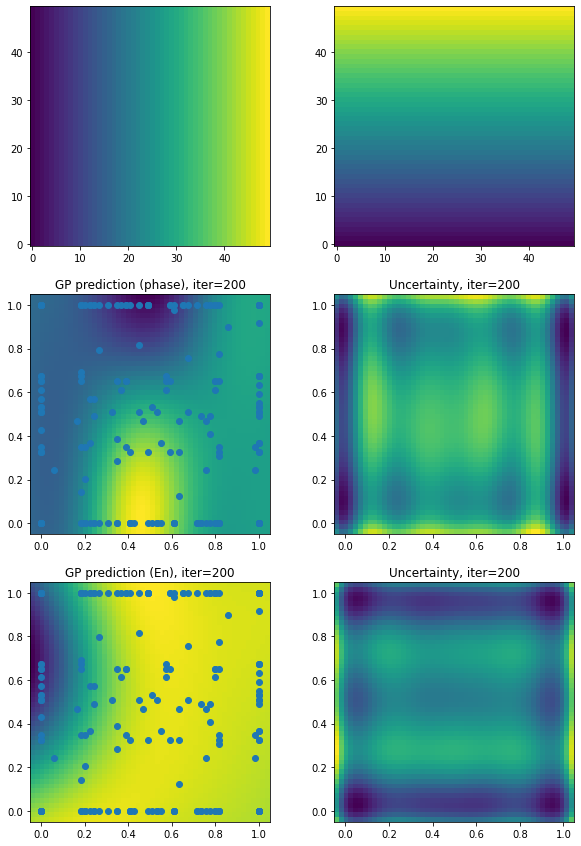

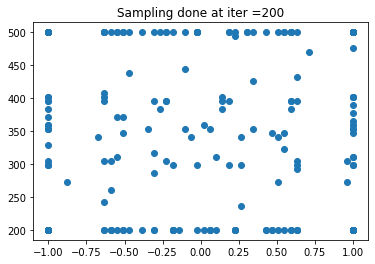

Function eval: 220
Function eval: 221
Function eval: 222
Function eval: 223
Function eval: 224
Function eval: 225
Function eval: 226
Function eval: 227
Function eval: 228
Function eval: 229
Function eval: 230
Function eval: 231
Function eval: 232
Function eval: 233
Function eval: 234
Function eval: 235
Function eval: 236
Function eval: 237
Function eval: 238
Function eval: 239
Function eval: 240
Function eval: 241
Function eval: 242
Function eval: 243
Function eval: 244
Function eval: 245
Function eval: 246
Function eval: 247
Function eval: 248
Function eval: 249
Function eval: 250
Max. sampling reached, model stopped


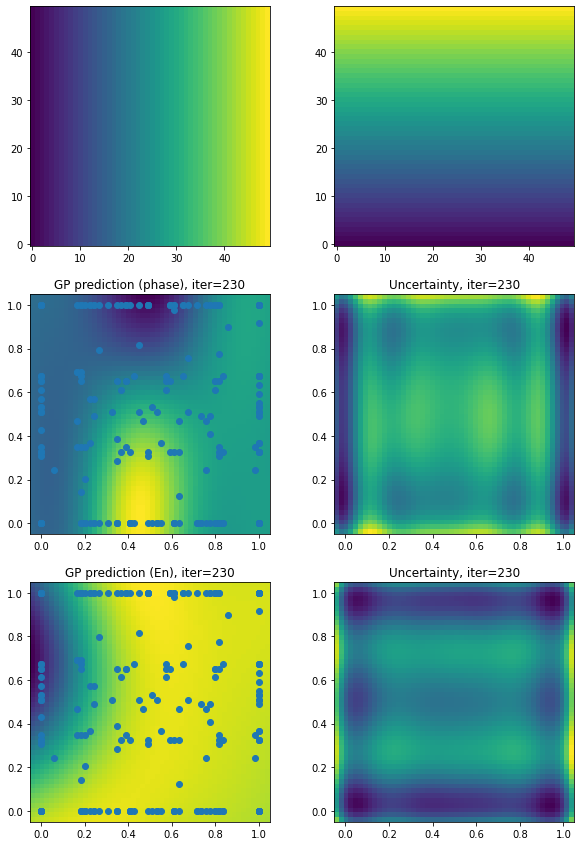

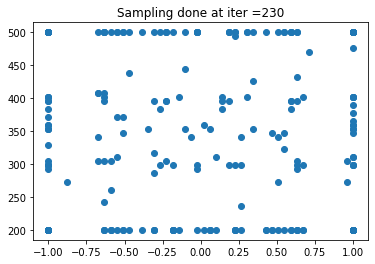

In [ ]:
###################################################

tkwargs = {
    "dtype": to.double,
    "device": to.device("cuda" if to.cuda.is_available() else "cpu"),
}



#Define parameter space based on above choice of params (2D only)
num_rows =50
num = 20  # Starting samples
N= 230

T= np.linspace(200, 500, num_rows)
um = np.linspace(-1, 1, num_rows)
rho = 10**-6
h= 50
dG = 0.2
l_da = 0.4
#prho = np.linspace(0, 6, nrow)
#h = np.linspace(5, 50, nrow)
#l_da = np.linspace(0.4, 2, nrow)

X1 = um
X2 = T
test_X1 = um
test_X2 = T
fix_x = [rho, h, dG, l_da]
#N = (0.5 * num_rows ** 2) - num  # Maximum evaluations
#N = int(N)
GP_BTO(X1, X2, fix_x, test_X1, test_X2, num_rows, num, N)



<h1> Analysis 2

**Parameter space**:

Temp: $T (K)= [200, 500]$
Strain mismatch: $u_m$ (%) $= [-1, 1]$

**Other fixed parameters**:

Partial O2 pressure, $\rho = 10^{0}$

film thickness, $h = 50 nm$ 

surface ion energy, $\Delta_G = 0.2 eV$

Width of dielectric gap, $\lambda = 0.2 nm$

Analysis:1
Analysis:2
Analysis:3
Analysis:4
Analysis:5
Analysis:6
Analysis:7
Analysis:8
Analysis:9
Analysis:10
Analysis:11
Analysis:12
Analysis:13
Analysis:14
Analysis:15
Analysis:16
Analysis:17
Analysis:18
Analysis:19
Analysis:20
Analysis:21
Analysis:22
Analysis:23
Analysis:24
Analysis:25
Analysis:26
Analysis:27
Analysis:28
Analysis:29
Analysis:30
Analysis:31
Analysis:32
Analysis:33
Analysis:34
Analysis:35
Analysis:36
Analysis:37
Analysis:38
Analysis:39
Analysis:40
Analysis:41
Analysis:42
Analysis:43
Analysis:44
Analysis:45
Analysis:46
Analysis:47
Analysis:48
Analysis:49
Analysis:50
Analysis:51
Analysis:52
Analysis:53
Analysis:54
Analysis:55
Analysis:56
Analysis:57
Analysis:58
Analysis:59
Analysis:60
Analysis:61
Analysis:62
Analysis:63
Analysis:64
Analysis:65
Analysis:66
Analysis:67
Analysis:68
Analysis:69
Analysis:70
Analysis:71
Analysis:72
Analysis:73
Analysis:74
Analysis:75
Analysis:76
Analysis:77
Analysis:78
Analysis:79
Analysis:80
Analysis:81
Analysis:82
Analysis:83
Analysis:84
A

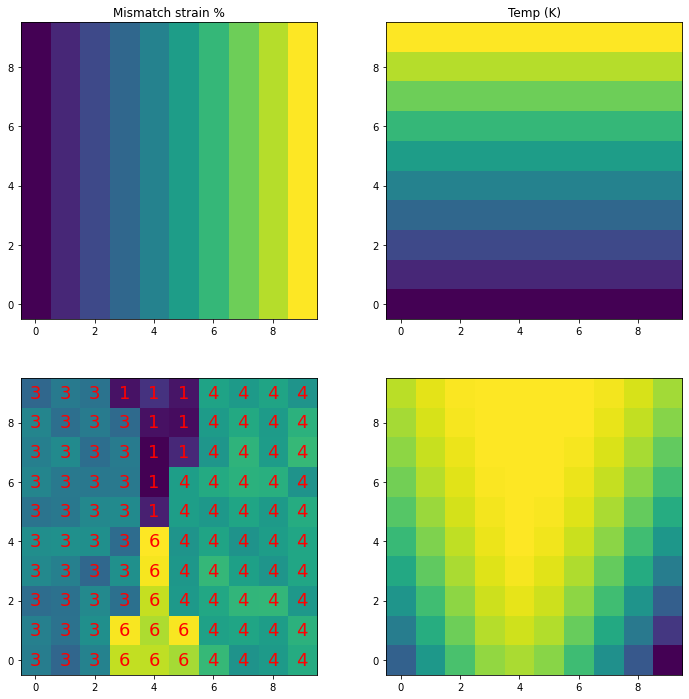

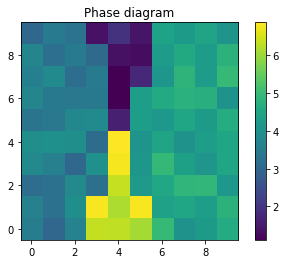

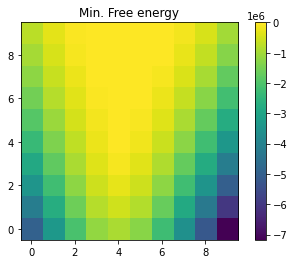

In [ ]:
# ###### Phase diagram################
num_rows = 10
T= np.linspace(200, 500, num_rows)
um = np.linspace(-1, 1, num_rows)
rho = 10**0
h= 50
dG = 0.2
l_da = 0.2
#prho = np.linspace(0, 6, nrow)
#h = np.linspace(5, 50, nrow)
#l_da = np.linspace(0.4, 2, nrow)

X1 = um
X2 = T

X1, X2 = np.meshgrid(X1, X2)
true_Y1 = np.zeros((len(X1), len(X1)))
true_Y2 = np.zeros((len(X1), len(X1)))
m=0
for t1, (x1, x2) in enumerate(zip(X1, X2)):
    for t2, (xx1, xx2) in enumerate(zip(x1, x2)):
        m = m + 1
        print("Analysis:" + str(m))
        #print(xx1)
        #print(xx2)
        objphase, objEn, sol, solEn, beta3 = BTOsystem(xx2, xx1, rho, h, dG, l_da)
        true_Y1[t1, t2] = objphase
        true_Y2[t1, t2] = objEn



# Plot Phase domain and free energy grid image for each A
fig, ax = plt.subplots(2, 2, figsize=(12, 12))
ax[0,0].imshow(X1, origin='bottom', cmap='viridis')
ax[0,1].imshow(X2, origin='bottom', cmap='viridis')
ax[1,0].imshow(true_Y1, origin='bottom', cmap='viridis')
ax[1,1].imshow(true_Y2, origin='bottom', cmap='viridis')
for i in range(0, true_Y1.shape[0]):
    for j in range(0, true_Y1.shape[1]):
        c1 = int(true_Y1[j, i])
        ax[1,0].text(i, j, str(c1), color='red', va='center', ha='center', size=18)


ax[0,0].set_title('Mismatch strain %')
ax[0,1].set_title('Temp (K)')
# ax[1,0].set_title('Phase diagram')
# ax[1,1].set_title('Min. Free energy')
plt.show()

#Adding colobar
plt.imshow(true_Y1, origin='bottom', cmap='viridis')
plt.title('Phase diagram')
plt.colorbar()
plt.show()

plt.imshow(true_Y2, origin='bottom', cmap='viridis')
plt.title('Min. Free energy')
plt.colorbar()
plt.show()


Now lets do dense exploration with cheap (low computational cost) surrogate GP model

Function evaluaton for initial randomly selected samples
Function eval: 1
Function eval: 2
Function eval: 3
Function eval: 4
Function eval: 5
Function eval: 6
Function eval: 7
Function eval: 8
Function eval: 9
Function eval: 10
Function eval: 11
Function eval: 12
Function eval: 13
Function eval: 14
Function eval: 15
Function eval: 16
Function eval: 17
Function eval: 18
Function eval: 19
Function eval: 20
Initial evaluation complete. Start GP explore


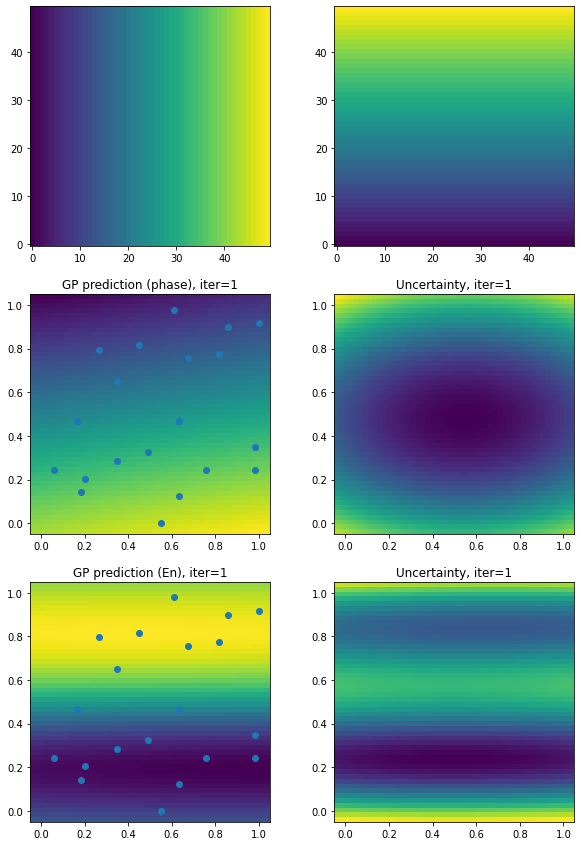

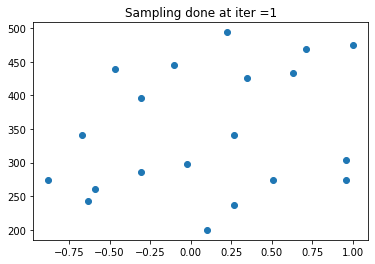

Function eval: 21
Function eval: 22
Function eval: 23
Function eval: 24
Function eval: 25
Function eval: 26
Function eval: 27
Function eval: 28
Function eval: 29


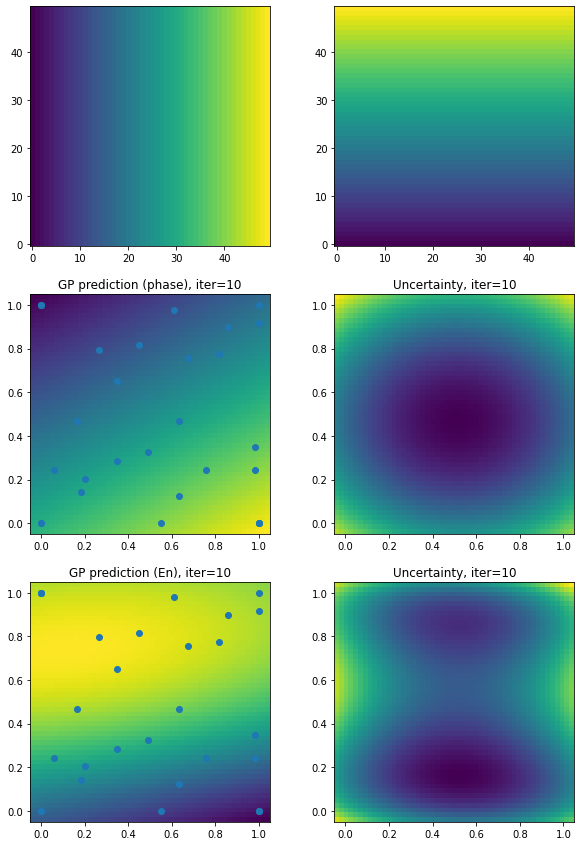

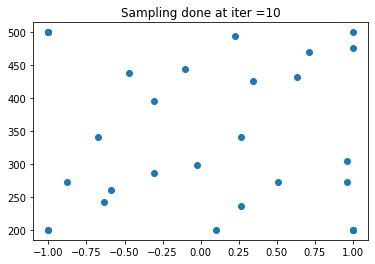

Function eval: 30
Function eval: 31
Function eval: 32
Function eval: 33
Function eval: 34
Function eval: 35
Function eval: 36
Function eval: 37
Function eval: 38
Function eval: 39
Function eval: 40
Function eval: 41
Function eval: 42
Function eval: 43
Function eval: 44
Function eval: 45
Function eval: 46
Function eval: 47
Function eval: 48
Function eval: 49


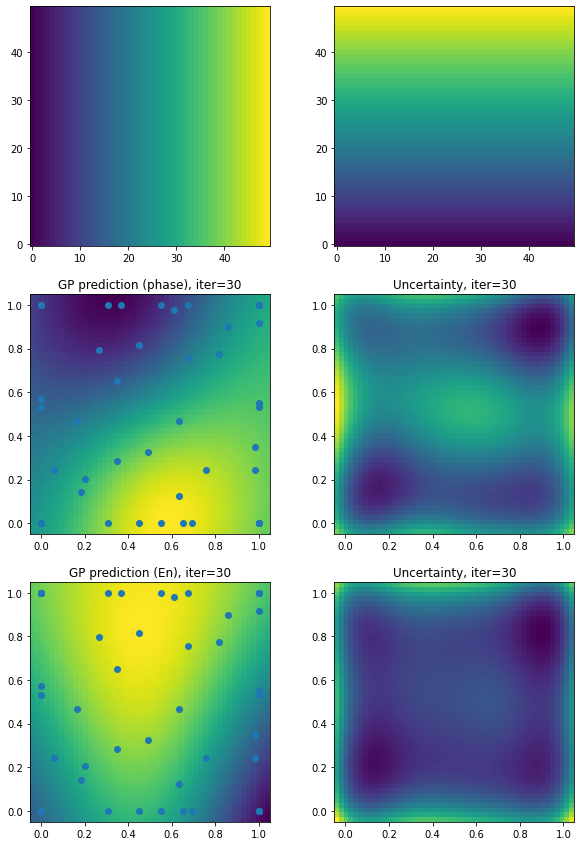

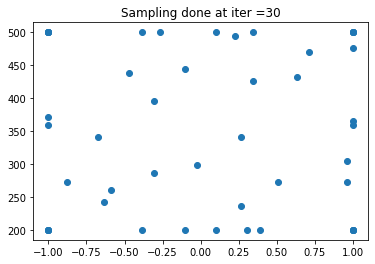

Function eval: 50
Function eval: 51
Function eval: 52
Function eval: 53
Function eval: 54
Function eval: 55
Function eval: 56
Function eval: 57
Function eval: 58
Function eval: 59
Function eval: 60
Function eval: 61
Function eval: 62
Function eval: 63
Function eval: 64
Function eval: 65
Function eval: 66
Function eval: 67
Function eval: 68
Function eval: 69


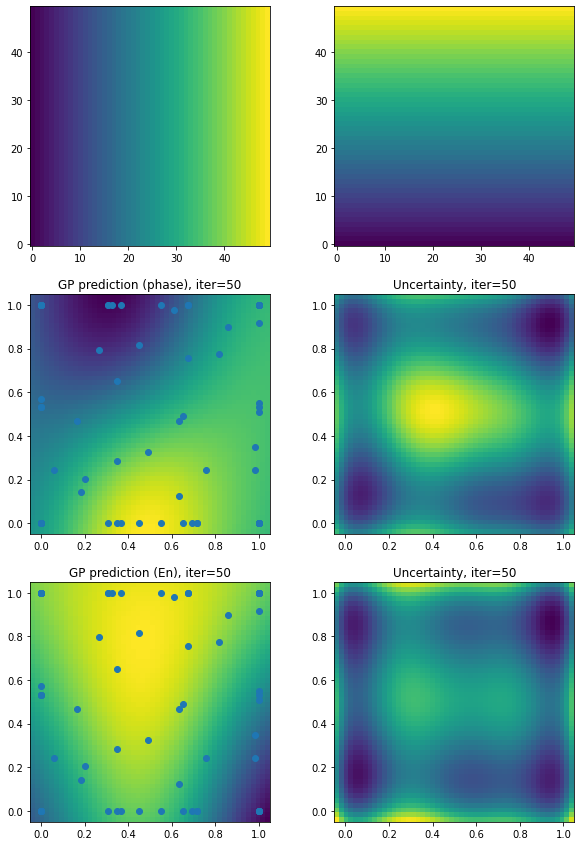

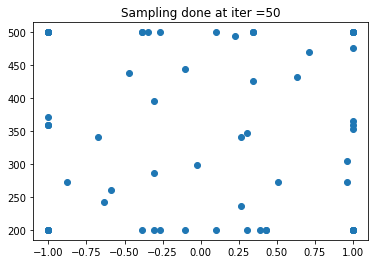

Function eval: 70
Function eval: 71
Function eval: 72
Function eval: 73
Function eval: 74
Function eval: 75
Function eval: 76
Function eval: 77
Function eval: 78
Function eval: 79
Function eval: 80
Function eval: 81
Function eval: 82
Function eval: 83
Function eval: 84
Function eval: 85
Function eval: 86
Function eval: 87
Function eval: 88
Function eval: 89
Function eval: 90
Function eval: 91
Function eval: 92
Function eval: 93
Function eval: 94
Function eval: 95
Function eval: 96
Function eval: 97
Function eval: 98
Function eval: 99


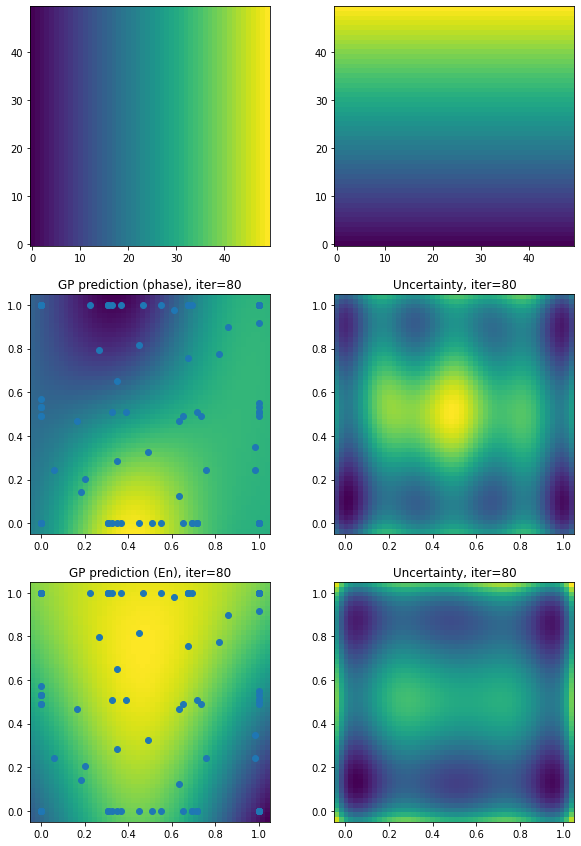

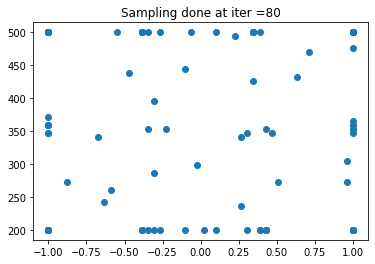

Function eval: 100
Function eval: 101
Function eval: 102
Function eval: 103
Function eval: 104
Function eval: 105
Function eval: 106
Function eval: 107
Function eval: 108
Function eval: 109
Function eval: 110
Function eval: 111
Function eval: 112
Function eval: 113
Function eval: 114
Function eval: 115
Function eval: 116
Function eval: 117
Function eval: 118
Function eval: 119


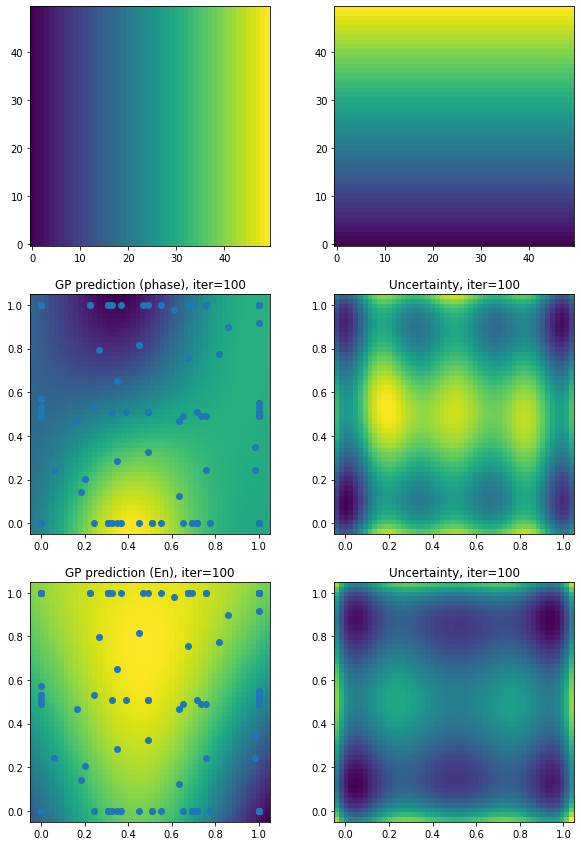

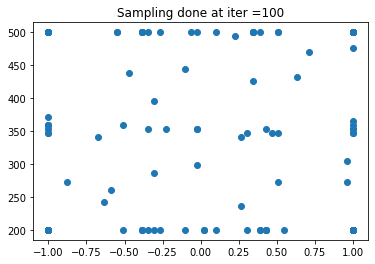

Function eval: 120
Function eval: 121
Function eval: 122
Function eval: 123
Function eval: 124
Function eval: 125
Function eval: 126
Function eval: 127
Function eval: 128
Function eval: 129
Function eval: 130
Function eval: 131
Function eval: 132
Function eval: 133
Function eval: 134
Function eval: 135
Function eval: 136
Function eval: 137
Function eval: 138
Function eval: 139
Function eval: 140
Function eval: 141
Function eval: 142
Function eval: 143
Function eval: 144
Function eval: 145
Function eval: 146
Function eval: 147
Function eval: 148
Function eval: 149
Function eval: 150
Function eval: 151
Function eval: 152
Function eval: 153
Function eval: 154
Function eval: 155
Function eval: 156
Function eval: 157
Function eval: 158
Function eval: 159
Function eval: 160
Function eval: 161
Function eval: 162
Function eval: 163
Function eval: 164
Function eval: 165
Function eval: 166
Function eval: 167
Function eval: 168
Function eval: 169


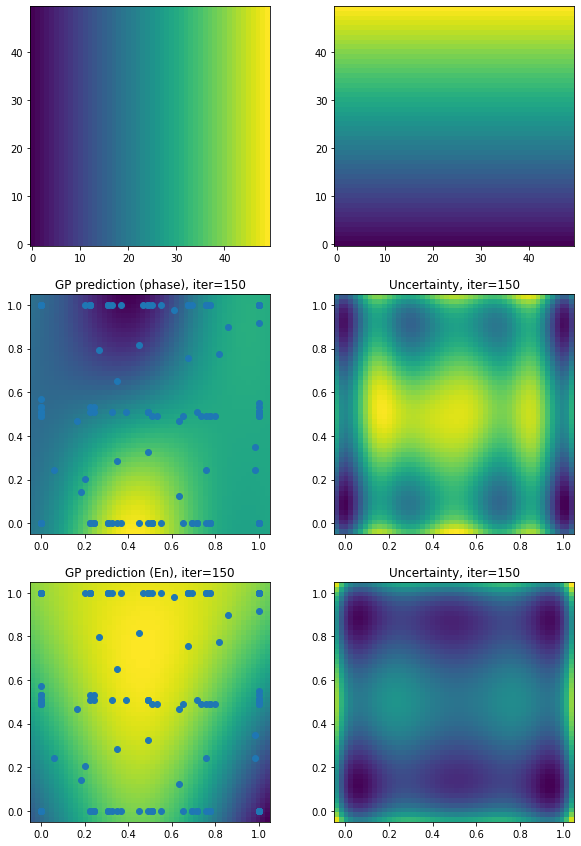

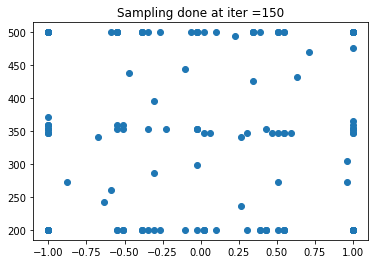

Function eval: 170
Function eval: 171
Function eval: 172
Function eval: 173
Function eval: 174
Function eval: 175
Function eval: 176
Function eval: 177
Function eval: 178
Function eval: 179
Function eval: 180
Function eval: 181
Function eval: 182
Function eval: 183
Function eval: 184
Function eval: 185
Function eval: 186
Function eval: 187
Function eval: 188
Function eval: 189
Function eval: 190
Function eval: 191
Function eval: 192
Function eval: 193
Function eval: 194
Function eval: 195
Function eval: 196
Function eval: 197
Function eval: 198
Function eval: 199
Function eval: 200
Function eval: 201
Function eval: 202
Function eval: 203
Function eval: 204
Function eval: 205
Function eval: 206
Function eval: 207
Function eval: 208
Function eval: 209
Function eval: 210
Function eval: 211
Function eval: 212
Function eval: 213
Function eval: 214
Function eval: 215
Function eval: 216
Function eval: 217
Function eval: 218
Function eval: 219


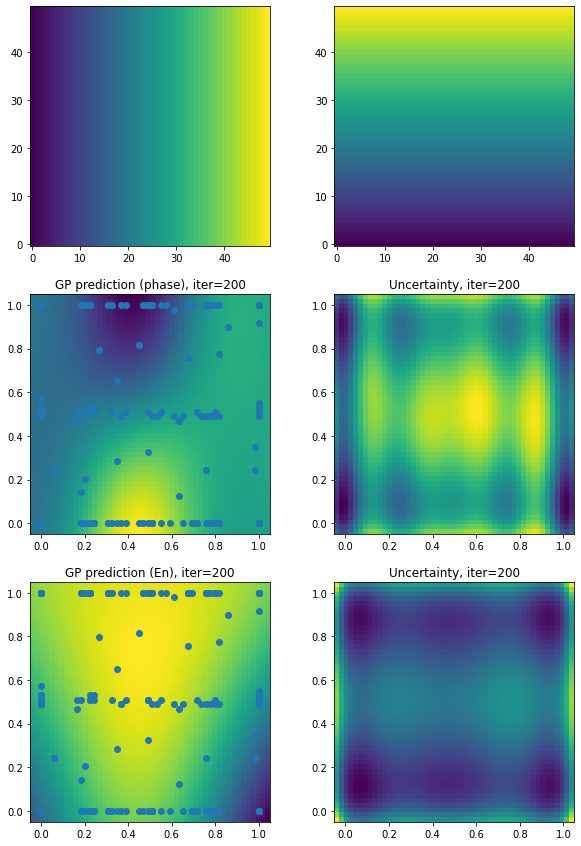

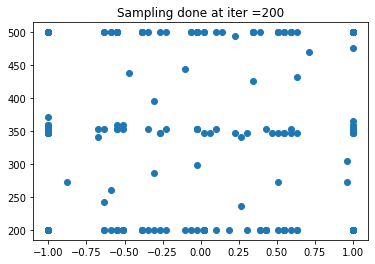

Function eval: 220
Function eval: 221
Function eval: 222
Function eval: 223
Function eval: 224
Function eval: 225
Function eval: 226
Function eval: 227
Function eval: 228
Function eval: 229
Function eval: 230
Function eval: 231
Function eval: 232
Function eval: 233
Function eval: 234
Function eval: 235
Function eval: 236
Function eval: 237
Function eval: 238
Function eval: 239
Function eval: 240
Function eval: 241
Function eval: 242
Function eval: 243
Function eval: 244
Function eval: 245
Function eval: 246
Function eval: 247
Function eval: 248
Function eval: 249
Function eval: 250
Max. sampling reached, model stopped


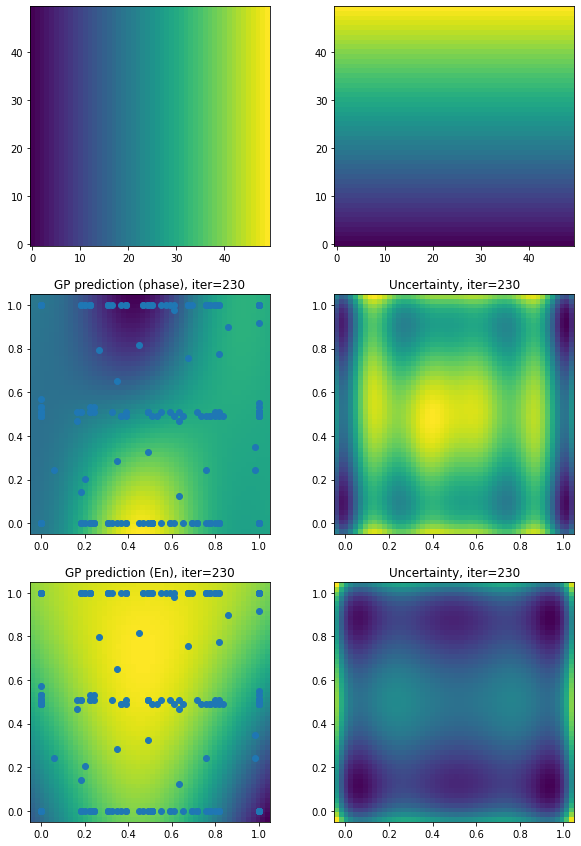

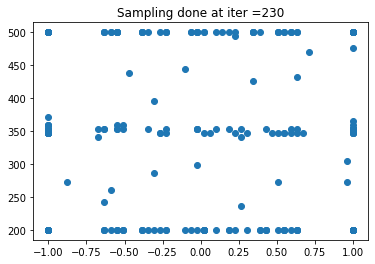

In [ ]:
###################################################

tkwargs = {
    "dtype": to.double,
    "device": to.device("cuda" if to.cuda.is_available() else "cpu"),
}



#Define parameter space based on above choice of params (2D only)
num_rows =50
num = 20  # Starting samples
N= 230

T= np.linspace(200, 500, num_rows)
um = np.linspace(-1, 1, num_rows)
rho = 10**0
h= 50
dG = 0.2
l_da = 0.2
#prho = np.linspace(0, 6, nrow)
#h = np.linspace(5, 50, nrow)
#l_da = np.linspace(0.4, 2, nrow)

X1 = um
X2 = T
test_X1 = um
test_X2 = T
fix_x = [rho, h, dG, l_da]
#N = (0.5 * num_rows ** 2) - num  # Maximum evaluations
#N = int(N)
GP_BTO(X1, X2, fix_x, test_X1, test_X2, num_rows, num, N)



<h1> Analysis 3

**Parameter space**:

Temp: $T (K)= [200, 500]$
Strain mismatch: $u_m$ (%) $= [-1, 1]$

**Other fixed parameters**:

Partial O2 pressure, $\rho = 10^{-6}$

film thickness, $h = 10 nm$ 

surface ion energy, $\Delta_G = 0.2 eV$

Width of dielectric gap, $\lambda = 2 nm$

Analysis:1
Analysis:2
Analysis:3
Analysis:4
Analysis:5
Analysis:6
Analysis:7
Analysis:8
Analysis:9
Analysis:10
Analysis:11
Analysis:12
Analysis:13
Analysis:14
Analysis:15
Analysis:16
Analysis:17
Analysis:18
Analysis:19
Analysis:20
Analysis:21
Analysis:22
Analysis:23
Analysis:24
Analysis:25
Analysis:26
Analysis:27
Analysis:28
Analysis:29
Analysis:30
Analysis:31
Analysis:32
Analysis:33
Analysis:34
Analysis:35
Analysis:36
Analysis:37
Analysis:38
Analysis:39
Analysis:40
Analysis:41
Analysis:42
Analysis:43
Analysis:44
Analysis:45
Analysis:46
Analysis:47
Analysis:48
Analysis:49
Analysis:50
Analysis:51
Analysis:52
Analysis:53
Analysis:54
Analysis:55
Analysis:56
Analysis:57
Analysis:58
Analysis:59
Analysis:60
Analysis:61
Analysis:62
Analysis:63
Analysis:64
Analysis:65
Analysis:66
Analysis:67
Analysis:68
Analysis:69
Analysis:70
Analysis:71
Analysis:72
Analysis:73
Analysis:74
Analysis:75
Analysis:76
Analysis:77
Analysis:78
Analysis:79
Analysis:80
Analysis:81
Analysis:82
Analysis:83
Analysis:84
A

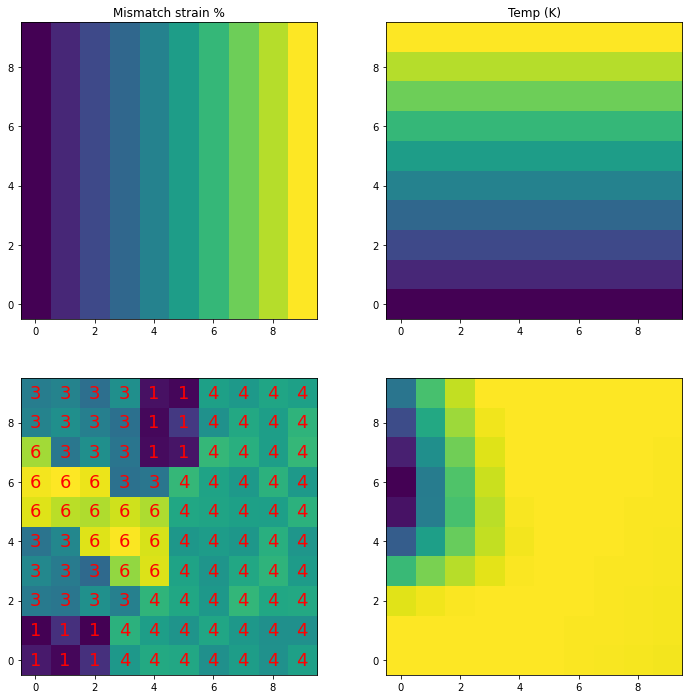

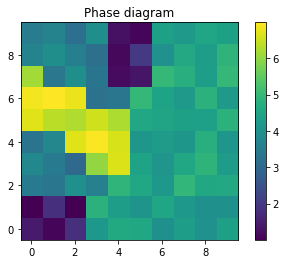

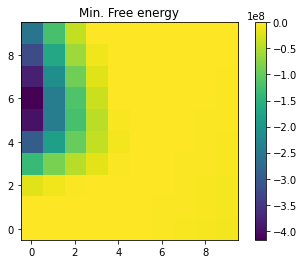

In [ ]:
# ###### Phase diagram################
num_rows = 10
T= np.linspace(200, 500, num_rows)
um = np.linspace(-1, 1, num_rows)
rho = 10**-6
h= 10
dG = 0.2
l_da = 2
#prho = np.linspace(0, 6, nrow)
#h = np.linspace(5, 50, nrow)
#l_da = np.linspace(0.4, 2, nrow)

X1 = um
X2 = T

X1, X2 = np.meshgrid(X1, X2)
true_Y1 = np.zeros((len(X1), len(X1)))
true_Y2 = np.zeros((len(X1), len(X1)))
m=0
for t1, (x1, x2) in enumerate(zip(X1, X2)):
    for t2, (xx1, xx2) in enumerate(zip(x1, x2)):
        m = m + 1
        print("Analysis:" + str(m))
        #print(xx1)
        #print(xx2)
        objphase, objEn, sol, solEn, beta3 = BTOsystem(xx2, xx1, rho, h, dG, l_da)
        true_Y1[t1, t2] = objphase
        true_Y2[t1, t2] = objEn



# Plot Phase domain and free energy grid image for each A
fig, ax = plt.subplots(2, 2, figsize=(12, 12))
ax[0,0].imshow(X1, origin='bottom', cmap='viridis')
ax[0,1].imshow(X2, origin='bottom', cmap='viridis')
ax[1,0].imshow(true_Y1, origin='bottom', cmap='viridis')
ax[1,1].imshow(true_Y2, origin='bottom', cmap='viridis')
for i in range(0, true_Y1.shape[0]):
    for j in range(0, true_Y1.shape[1]):
        c1 = int(true_Y1[j, i])
        ax[1,0].text(i, j, str(c1), color='red', va='center', ha='center', size=18)


ax[0,0].set_title('Mismatch strain %')
ax[0,1].set_title('Temp (K)')
# ax[1,0].set_title('Phase diagram')
# ax[1,1].set_title('Min. Free energy')
plt.show()

#Adding colobar
plt.imshow(true_Y1, origin='bottom', cmap='viridis')
plt.title('Phase diagram')
plt.colorbar()
plt.show()

plt.imshow(true_Y2, origin='bottom', cmap='viridis')
plt.title('Min. Free energy')
plt.colorbar()
plt.show()


Now lets do dense exploration with cheap (low computational cost) surrogate GP model

Function evaluaton for initial randomly selected samples
Function eval: 1
Function eval: 2
Function eval: 3
Function eval: 4
Function eval: 5
Function eval: 6
Function eval: 7
Function eval: 8
Function eval: 9
Function eval: 10
Function eval: 11
Function eval: 12
Function eval: 13
Function eval: 14
Function eval: 15
Function eval: 16
Function eval: 17
Function eval: 18
Function eval: 19
Function eval: 20
Initial evaluation complete. Start GP explore


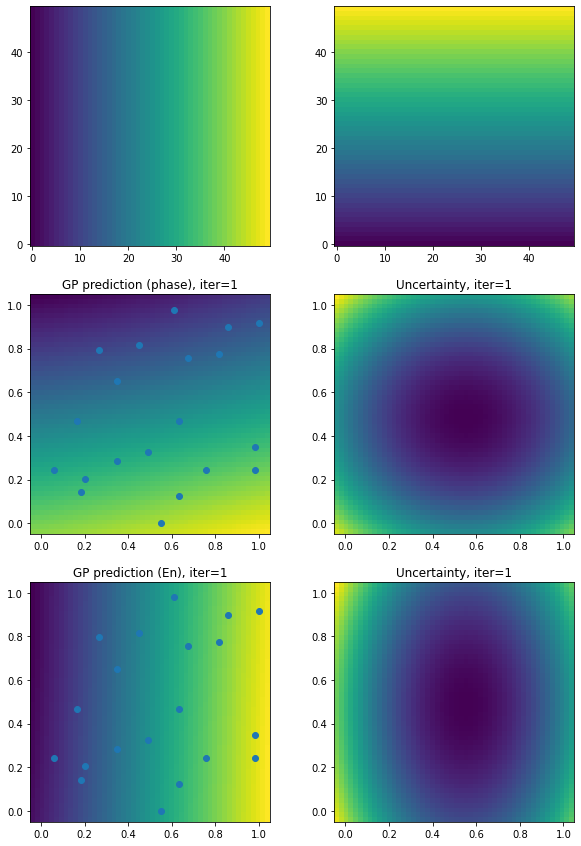

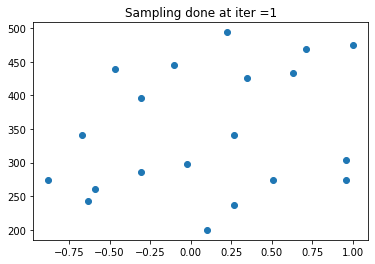

Function eval: 21
Function eval: 22
Function eval: 23
Function eval: 24
Function eval: 25
Function eval: 26
Function eval: 27
Function eval: 28
Function eval: 29


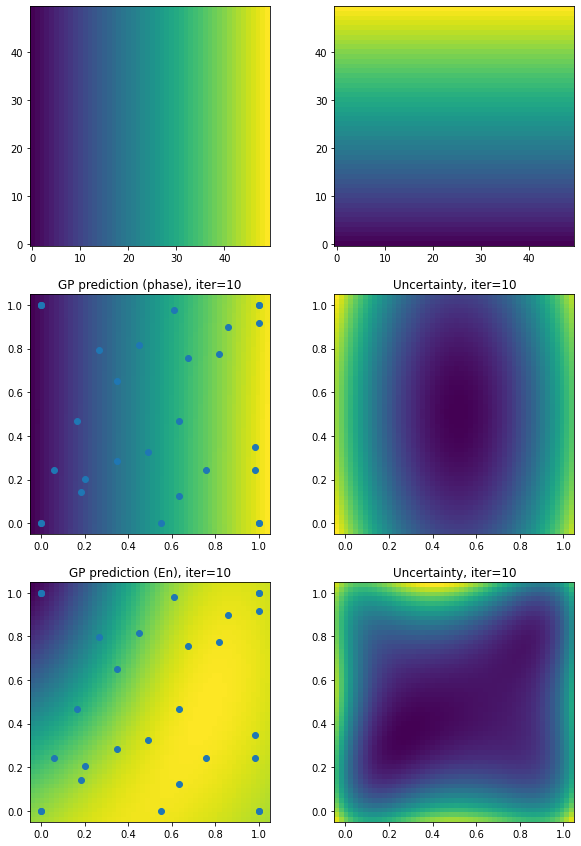

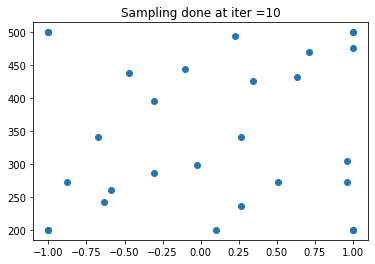

Function eval: 30
Function eval: 31
Function eval: 32
Function eval: 33
Function eval: 34
Function eval: 35
Function eval: 36
Function eval: 37
Function eval: 38
Function eval: 39
Function eval: 40
Function eval: 41
Function eval: 42
Function eval: 43
Function eval: 44
Function eval: 45
Function eval: 46
Function eval: 47
Function eval: 48
Function eval: 49


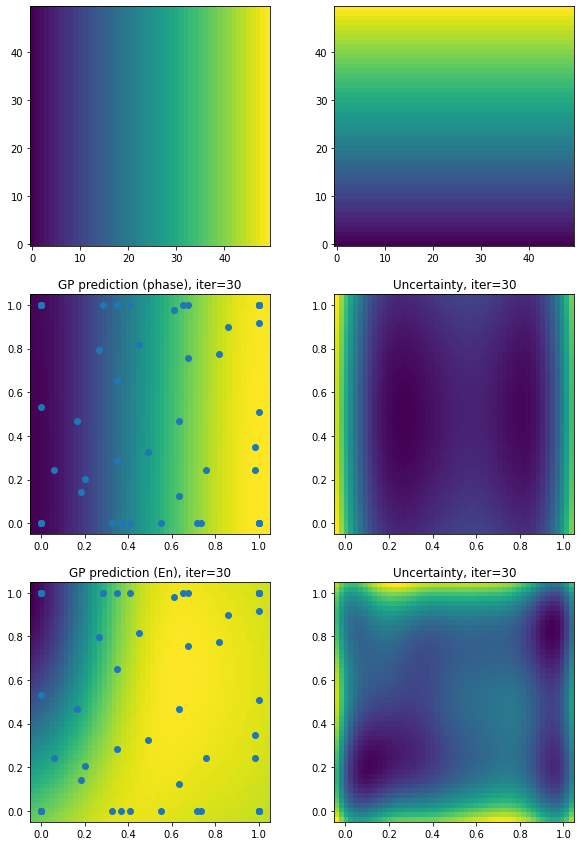

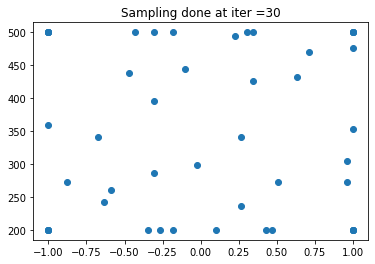

Function eval: 50
Function eval: 51
Function eval: 52
Function eval: 53
Function eval: 54
Function eval: 55
Function eval: 56
Function eval: 57
Function eval: 58
Function eval: 59
Function eval: 60
Function eval: 61
Function eval: 62
Function eval: 63
Function eval: 64
Function eval: 65
Function eval: 66
Function eval: 67
Function eval: 68
Function eval: 69


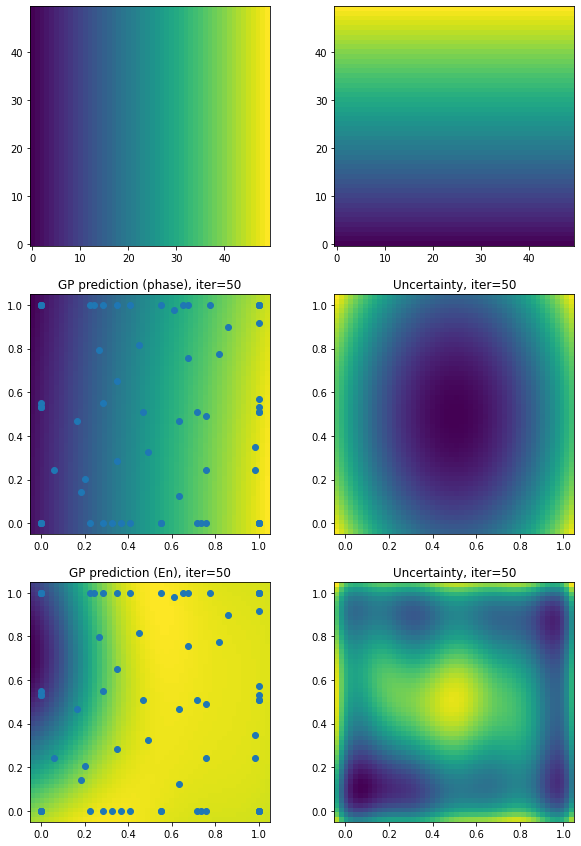

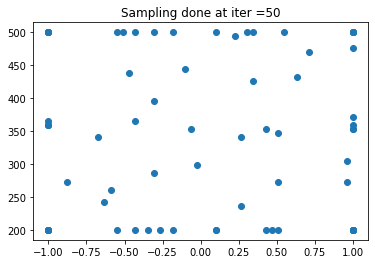

Function eval: 70
Function eval: 71
Function eval: 72
Function eval: 73
Function eval: 74
Function eval: 75
Function eval: 76
Function eval: 77
Function eval: 78
Function eval: 79
Function eval: 80
Function eval: 81
Function eval: 82
Function eval: 83
Function eval: 84
Function eval: 85
Function eval: 86
Function eval: 87
Function eval: 88
Function eval: 89
Function eval: 90
Function eval: 91
Function eval: 92
Function eval: 93
Function eval: 94
Function eval: 95
Function eval: 96
Function eval: 97
Function eval: 98
Function eval: 99


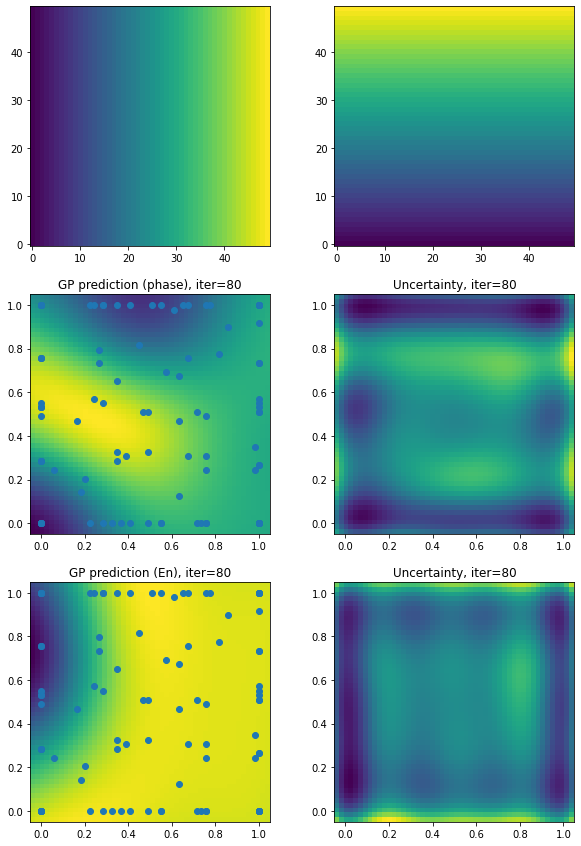

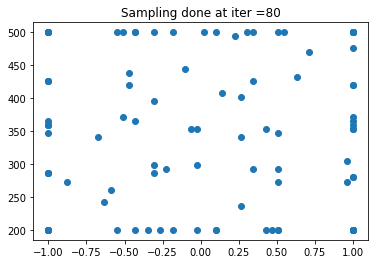

Function eval: 100
Function eval: 101
Function eval: 102
Function eval: 103
Function eval: 104
Function eval: 105
Function eval: 106
Function eval: 107
Function eval: 108
Function eval: 109
Function eval: 110
Function eval: 111
Function eval: 112
Function eval: 113
Function eval: 114
Function eval: 115
Function eval: 116
Function eval: 117
Function eval: 118
Function eval: 119


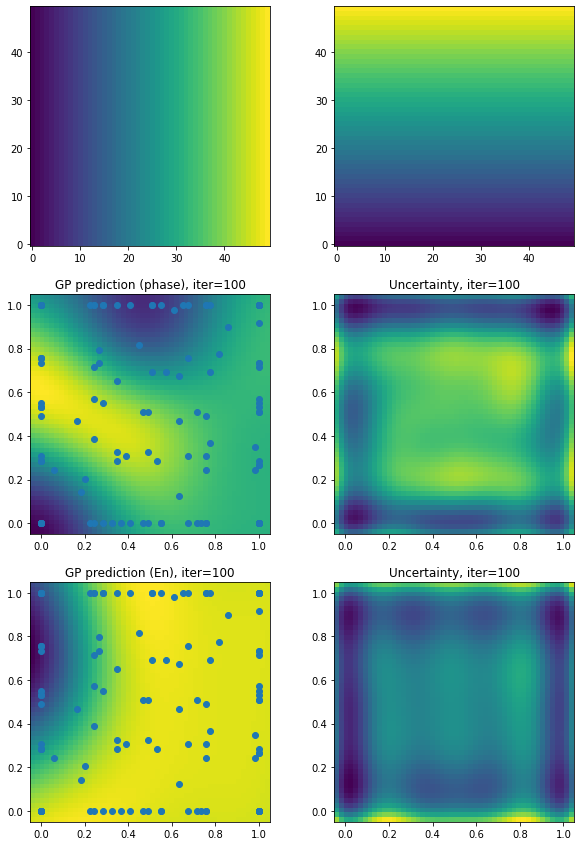

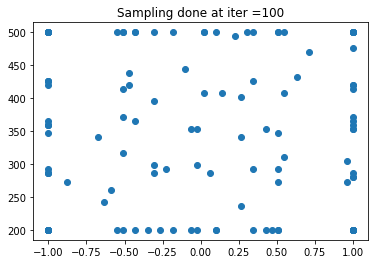

Function eval: 120
Function eval: 121
Function eval: 122
Function eval: 123
Function eval: 124
Function eval: 125
Function eval: 126
Function eval: 127
Function eval: 128
Function eval: 129
Function eval: 130
Function eval: 131
Function eval: 132
Function eval: 133
Function eval: 134
Function eval: 135
Function eval: 136
Function eval: 137
Function eval: 138
Function eval: 139
Function eval: 140
Function eval: 141
Function eval: 142
Function eval: 143
Function eval: 144
Function eval: 145
Function eval: 146
Function eval: 147
Function eval: 148
Function eval: 149
Function eval: 150
Function eval: 151
Function eval: 152
Function eval: 153
Function eval: 154
Function eval: 155
Function eval: 156
Function eval: 157
Function eval: 158
Function eval: 159
Function eval: 160
Function eval: 161
Function eval: 162
Function eval: 163
Function eval: 164
Function eval: 165
Function eval: 166
Function eval: 167
Function eval: 168
Function eval: 169


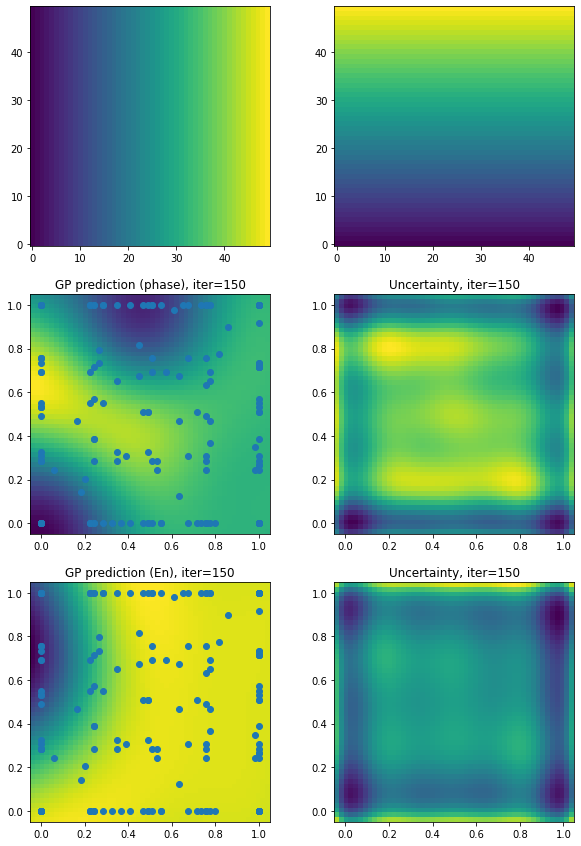

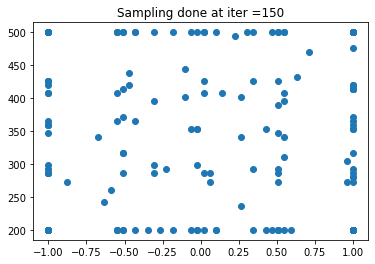

Function eval: 170
Function eval: 171
Function eval: 172
Function eval: 173
Function eval: 174
Function eval: 175
Function eval: 176
Function eval: 177
Function eval: 178
Function eval: 179
Function eval: 180
Function eval: 181
Function eval: 182
Function eval: 183
Function eval: 184
Function eval: 185
Function eval: 186
Function eval: 187
Function eval: 188
Function eval: 189
Function eval: 190
Function eval: 191
Function eval: 192
Function eval: 193
Function eval: 194
Function eval: 195
Function eval: 196
Function eval: 197
Function eval: 198
Function eval: 199
Function eval: 200
Function eval: 201
Function eval: 202
Function eval: 203
Function eval: 204
Function eval: 205
Function eval: 206
Function eval: 207
Function eval: 208
Function eval: 209
Function eval: 210
Function eval: 211
Function eval: 212
Function eval: 213
Function eval: 214
Function eval: 215
Function eval: 216
Function eval: 217
Function eval: 218
Function eval: 219


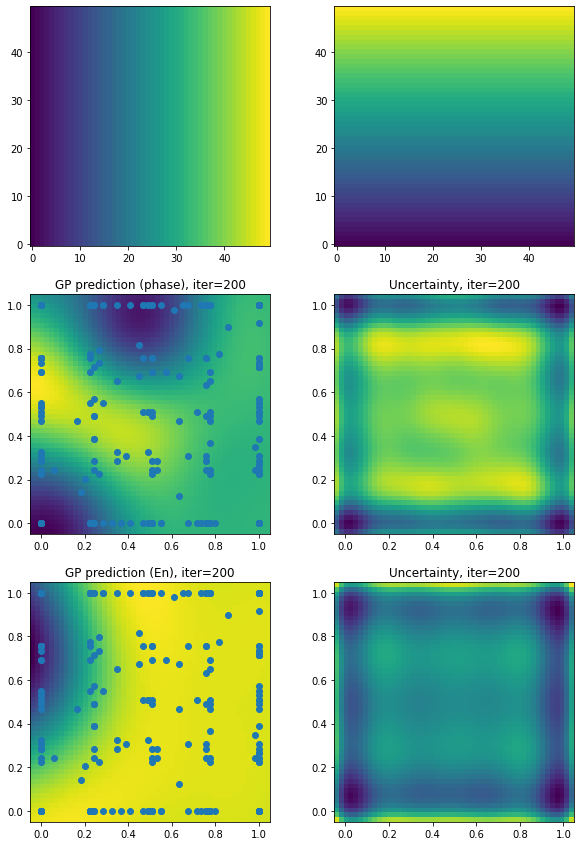

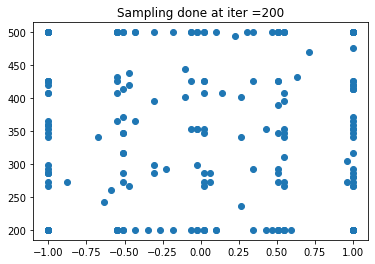

Function eval: 220
Function eval: 221
Function eval: 222
Function eval: 223
Function eval: 224
Function eval: 225
Function eval: 226
Function eval: 227
Function eval: 228
Function eval: 229
Function eval: 230
Function eval: 231
Function eval: 232
Function eval: 233
Function eval: 234
Function eval: 235
Function eval: 236
Function eval: 237
Function eval: 238
Function eval: 239
Function eval: 240
Function eval: 241
Function eval: 242
Function eval: 243
Function eval: 244
Function eval: 245
Function eval: 246
Function eval: 247
Function eval: 248
Function eval: 249
Function eval: 250
Max. sampling reached, model stopped


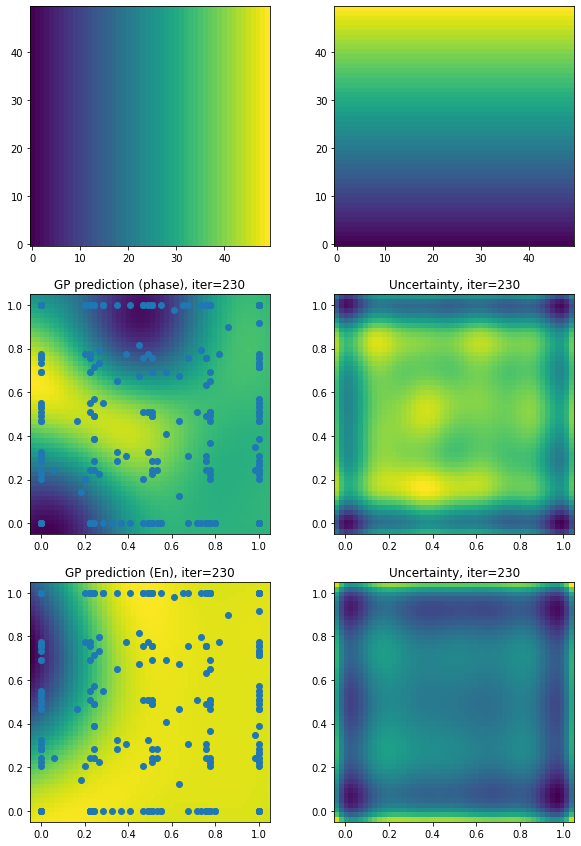

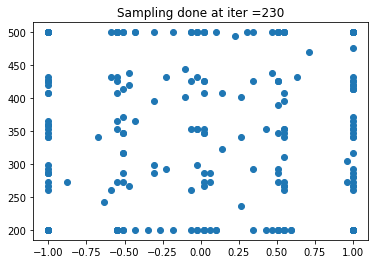

In [ ]:
###################################################

tkwargs = {
    "dtype": to.double,
    "device": to.device("cuda" if to.cuda.is_available() else "cpu"),
}



#Define parameter space based on above choice of params (2D only)
num_rows =50
num = 20  # Starting samples
N= 230

T= np.linspace(200, 500, num_rows)
um = np.linspace(-1, 1, num_rows)
rho = 10**-6
h= 10
dG = 0.2
l_da = 2
#prho = np.linspace(0, 6, nrow)
#h = np.linspace(5, 50, nrow)
#l_da = np.linspace(0.4, 2, nrow)

X1 = um
X2 = T
test_X1 = um
test_X2 = T
fix_x = [rho, h, dG, l_da]
#N = (0.5 * num_rows ** 2) - num  # Maximum evaluations
#N = int(N)
GP_BTO(X1, X2, fix_x, test_X1, test_X2, num_rows, num, N)

